# Lateral ventricle volume trajectories and response inhibition - lda

Copyright (c) 2019, Arvid Lundervold

*Astri J. Lundervold, Alexandra Vik, Arvid Lundervold* <br>
**Lateral ventricle volume trajectories predict response inhibition in older age - a
longitudinal brain imaging and machine learning approach** <br>

The linear mixed effect model (LME) was fitted to the data, i.e.

$$\text{Vol}_{ij} = \beta_0 + \beta_1 \text{Age}_{ij} + (b_{0i} + b_{1i} \text{Age}_{ij}) + \epsilon_{ij}$$

Here, $\text{Vol}_{ij}$ the continuous *response variable* in the model is volume of left (right) latreral ventricle in subject $i$ ($i=1,\ldots,N$) at wave $j$ ($j=1,\ldots,n_i$). In our case we have $N=74$ and three wase with complete data, i.e. $n_i=3$ for all $i$. $\text{Age}_{ij}$ is age (in years) of subject $j$ at wave $j$, and a *predictor variable* in the model.

The model parameterrs $\beta_0$ and $\beta_1$ are *fixed effects* parameters.  The variables $b_{0i}$ and $b_{1i}$ 
($i=1,\ldots,N$) are the *random effects* parameters, assumed to be normally distributed witrh zero mean. They denote individual deviations in intercept ($b_{0i}$) and slope ($b_{1i}$), respectiveley, from the group-level fixed effect.
Finally, the random residual errors $\epsilon_{ij}$ are assumed to be independent and normally distributed (i.i.d) with zero mean and constant variance $\sigma_\epsilon^2$.

**Select if eTIV-normalization of lateral ventricle volumes should be used or not**

In [3]:
eTIV_NORMALIZED = False

### Packages and libraries
**`rpy2` should be tested through `0.0-test.ipynb`**

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from matplotlib import pyplot as plt
import rpy2
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()
from rpy2.robjects.lib.tidyr import DataFrame

# Enable inline plotting
%matplotlib inline
from IPython.display import Image

## Reading data

In [5]:
fn_data = '../data/01_lvv_ri_renamed_data.csv'
df = pd.read_csv(fn_data)

In [6]:
df.head().T

,0,1,2,3,4
subj,subj_01,subj_02,subj_03,subj_04,subj_05
gender,F,M,M,M,M
yrW1,56.63,49.07,74.61,56.23,63.22
yrW2,60.35,52.58,78.14,59.78,67
yrW3,62.62,55.05,80.59,62.68,69.53
left_lvvW1,5321.4,11038.6,29718.4,21830.1,17205.1
left_lvvW2,5063.6,11912.2,32265.1,23933.6,16970.1
left_lvvW3,5368.3,12313.3,35887,26164.2,15858.1
right_lvvW1,6855.2,10611.6,34241,15243.9,13962.1
right_lvvW2,6729.2,11774.8,37155.2,16505.1,13755.5


In [7]:
if eTIV_NORMALIZED:
    for col in ['left_lvvW1', 'left_lvvW2', 'left_lvvW3',
                'right_lvvW1', 'right_lvvW2','right_lvvW3']:
        df[col] = df[col]/df['eTIV']

df.head().T

,0,1,2,3,4
subj,subj_01,subj_02,subj_03,subj_04,subj_05
gender,F,M,M,M,M
yrW1,56.63,49.07,74.61,56.23,63.22
yrW2,60.35,52.58,78.14,59.78,67
yrW3,62.62,55.05,80.59,62.68,69.53
left_lvvW1,5321.4,11038.6,29718.4,21830.1,17205.1
left_lvvW2,5063.6,11912.2,32265.1,23933.6,16970.1
left_lvvW3,5368.3,12313.3,35887,26164.2,15858.1
right_lvvW1,6855.2,10611.6,34241,15243.9,13962.1
right_lvvW2,6729.2,11774.8,37155.2,16505.1,13755.5


 ## Prepare for using lmer in R for linear mixed-effects (LME) analysis
 **`rpy2` should be tested through `0.0-test.ipynb`**

In [8]:
%reload_ext rpy2.ipython

In [9]:
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
from rpy2.robjects.packages import importr
utils = importr('utils')
# If needed to install - uncomment the following ('stringi', needed for 'tidyr' might be  a challenge on MacOS)
#utils.install_packages('tidyr')
#utils.install_packages('lazyeval')
#utils.install_packages('lme4')
#utils.install_packages('ggplot2')
#utils.install_packages('GGally')
#utils.install_packages('foreign')

In [12]:
%R R.version$system

array(['x86_64, mingw32'], dtype='<U15')

In [13]:
%R R.version$version.string

array(['R version 3.4.1 (2017-06-30)'], dtype='<U28')

In [14]:
%R library(rlang); library(Rcpp); library(ggplot2); library(lme4)

array(['lme4', 'Matrix', 'ggplot2', 'Rcpp', 'rlang', 'lazyeval', 'dplyr',
       'tidyr', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

### Make data frame to long format

In [15]:
%%R -i df -i eTIV_NORMALIZED

df.all <- df
NOR <- eTIV_NORMALIZED

mycols1 = c('subj','yrW1', 'yrW2', 'yrW3')
mycols2 = c('subj','left_lvvW1','left_lvvW2', 'left_lvvW3')
mycols3 = c('subj','right_lvvW1','right_lvvW2', 'right_lvvW3')

df.sel1 <- select(df.all, mycols1)
df.sel2 <- select(df.all, mycols2)
df.sel3 <- select(df.all, mycols3)
                  
df.long1 <- gather(df.sel1, Wave, Age, yrW1:yrW3, factor_key=TRUE)
levels(df.long1$Wave)[levels(df.long1$Wave)=="yrW1"] <- "1"
levels(df.long1$Wave)[levels(df.long1$Wave)=="yrW2"] <- "2"
levels(df.long1$Wave)[levels(df.long1$Wave)=="yrW3"] <- "3"

if (NOR) {
df.long2 <- gather(df.sel2, Wave, Volume_eTIVnorm, left_lvvW1:left_lvvW3, factor_key=TRUE)
} else {
df.long2 <- gather(df.sel2, Wave, Volume, left_lvvW1:left_lvvW3, factor_key=TRUE)
}
levels(df.long2$Wave)[levels(df.long2$Wave)=="left_lvvW1"] <- "1"
levels(df.long2$Wave)[levels(df.long2$Wave)=="left_lvvW2"] <- "2"
levels(df.long2$Wave)[levels(df.long2$Wave)=="left_lvvW3"] <- "3"

if (NOR) {
df.long3 <- gather(df.sel3, Wave, Volume_eTIVnorm, right_lvvW1:right_lvvW3, factor_key=TRUE)
} else {
df.long3 <- gather(df.sel3, Wave, Volume, right_lvvW1:right_lvvW3, factor_key=TRUE)
}

levels(df.long3$Wave)[levels(df.long3$Wave)=="right_lvvW1"] <- "1"
levels(df.long3$Wave)[levels(df.long3$Wave)=="right_lvvW2"] <- "2"
levels(df.long3$Wave)[levels(df.long3$Wave)=="right_lvvW3"] <- "3"

df.longL <- merge(x = df.long1, y = df.long2, by.x = c("subj","Wave"), by.y = c("subj","Wave"))
df.longR <- merge(x = df.long1, y = df.long3, by.x = c("subj","Wave"), by.y = c("subj","Wave"))

# Left: Sort by Subject first, then by Wave
df.longL <- df.longL[order(df.longL$subj, df.longL$Wave), ]
df.longL$Region <- "LeftLateralVentricle"
# Reorder columns
df.longL$subj = substr(df.longL$subj, start=6, stop=7)
if (NOR) {
df.longL <- df.longL[c("subj", "Region", "Wave", "Age", "Volume_eTIVnorm")]
} else {
df.longL <- df.longL[c("subj", "Region", "Wave", "Age", "Volume")]   
}
# https://support.rstudio.com/hc/en-us/articles/205175388-Using-the-Data-Viewer
# View(df.long))

# Right: Sort by Subject first, then by Wave
df.longR <- df.longR[order(df.longR$subj, df.longR$Wave), ]
df.longR$Region <- "RightLateralVentricle"
# Reorder columns
df.longR$subj = substr(df.longR$subj, start=6, stop=7)
if (NOR) {
df.longR <- df.longR[c("subj", "Region", "Wave", "Age", "Volume_eTIVnorm")]
} else {
df.longR <- df.longR[c("subj", "Region", "Wave", "Age", "Volume")]   
}

In [16]:
%R names(df.longR)

array(['subj', 'Region', 'Wave', 'Age', 'Volume'], dtype='<U6')

In [17]:
# Check: https://stackoverflow.com/questions/54904223/importing-rds-files-in-python-to-be-read-as-a-dataframe
# pip install --upgrade rpy2 pandas
# I had the same issue but could'nt upgrade rpy2. Downgrading pandas from 0.24 to 0.23.4 did the job as well
# conda install pandas=0.23.4
#%R head(df.longR)

In [18]:
# Converting the R dataframes to Pandas DataFrames using Rpy2
# https://pandas.pydata.org/pandas-docs/stable/r_interface.html
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

#pd_df_long_L = r['df.longL']
#pd_df_long_R = r['df.longR']

In [19]:
#pd_df_long_L.head()

In [20]:
#pd_df_long_R.head()

In [21]:
#pd_df_long_L.describe()

In [22]:
# Save the long formated data to the present repository as .csv
if eTIV_NORMALIZED:
    #    pd_df_long_L.to_csv('../results/02_lvv_ri_left_long_data_eTIV_norm.csv', header=True, index=False)
    #    pd_df_long_R.to_csv('../results/02_lvv_ri_right_long_data_eTIV_norm.csv', header=True, index=False)
else:
    #    pd_df_long_L.to_csv('../results/02_lvv_ri_left_long_data.csv', header=True, index=False)
    #    pd_df_long_R.to_csv('../results/02_lvv_ri_right_long_data.csv', header=True, index=False)  

IndentationError: expected an indented block (<ipython-input-22-1d8ccbfba96e>, line 5)

### Fit linear ordinary least squares (OLS) and mixed-effects models for Left and Right hemisphere

In [23]:
%%R -i eTIV_NORMALIZED
NOR <- eTIV_NORMALIZED

library(lme4)

if (NOR) {
lm.1.L <- lm(Volume_eTIVnorm ~ Age, data = df.longL)
lmer.1.L <- lmer(Volume_eTIVnorm ~ Age + (Age | subj), data=df.longL, REML=TRUE)

lm.1.R <- lm(Volume_eTIVnorm ~ Age, data = df.longR)
lmer.1.R <- lmer(Volume_eTIVnorm ~ Age + (Age | subj), data=df.longR, REML=TRUE)
} else {
lm.1.L <- lm(Volume ~ Age, data = df.longL)
lmer.1.L <- lmer(Volume ~ Age + (Age | subj), data=df.longL, REML=TRUE)

lm.1.R <- lm(Volume ~ Age, data = df.longR)
lmer.1.R <- lmer(Volume ~ Age + (Age | subj), data=df.longR, REML=TRUE)
}

In [24]:
%%R

# Left
mylm <- lm.1.L
mylmer <- lmer.1.L

# Get the coefficients of fixed and random effects
a0.L <- coef(mylm)[[1]]
a1.L <- coef(mylm)[[2]]
beta0.L <- fixef(mylmer)[[1]]
beta1.L <- fixef(mylmer)[[2]]
b.L <- ranef(mylmer)
b0i.L <- b.L$subj[,1]
b1i.L <- b.L$subj[,2]

beta01.L = sprintf("Fixed effects (left LV): beta0.L = %.2f ; beta1.L = %.2f", beta0.L, beta1.L)

df.lmer.L <- merge(x = df.sel1, y = df.sel2, by.x = c("subj"), by.y = c("subj"))
df.lmer.L$b0i <- b0i.L
df.lmer.L$b1i <- b1i.L
df.lmer.L$beta0plusb0i <- b0i.L + beta0.L
df.lmer.L$beta1plusb1i <- b1i.L + beta1.L

df.lmer.L$gender <- df.all$gender
df.lmer.L$RI <- df.all$RI
df.lmer.L$RIresid <- df.all$resid12

In [25]:
%R print(head(df.lmer.L, 10))

,subj,yrW1,yrW2,yrW3,left_lvvW1,left_lvvW2,left_lvvW3,b0i,b1i,beta0plusb0i,beta1plusb1i,gender,RI
0,subj_01,56.63,60.35,62.62,5321.4,5063.6,5368.3,15699.150627,-401.810897,3658.786281,26.752415,F,66.0
1,subj_02,49.07,52.58,55.05,11038.6,11912.2,12313.3,11389.854989,-191.145013,-650.509357,237.418299,M,85.0
2,subj_03,74.61,78.14,80.59,29718.4,32265.1,35887.0,-27639.508439,501.100149,-39679.872785,929.663462,M,71.0
3,subj_04,56.23,59.78,62.68,21830.1,23933.6,26164.2,-3996.407933,242.911455,-16036.772279,671.474767,M,41.0
4,subj_05,63.22,67.00,69.53,17205.1,16970.1,15858.1,35508.952193,-530.848189,23468.587847,-102.284877,M,62.0
5,subj_06,60.51,64.29,66.82,14800.4,18814.5,19464.2,-16737.988507,299.054929,-28778.352853,727.618241,F,89.0
6,subj_07,58.87,62.42,64.87,19864.5,20962.8,22141.1,7815.334255,-22.460468,-4225.030091,406.102844,M,46.0
7,subj_08,69.54,73.04,75.47,12080.9,12293.3,12915.2,12867.693521,-268.917720,827.329175,159.645592,M,57.0
8,subj_09,59.33,62.98,65.59,17406.7,20601.1,23556.7,-25364.791714,496.313379,-37405.156060,924.876692,M,48.0
9,subj_10,54.63,58.18,60.63,12438.3,13028.2,13901.2,10080.765796,-167.751181,-1959.598550,260.812131,F,50.0


In [26]:
%R print(beta01.L)

array(['Fixed effects (left LV): beta0.L = -12040.36 ; beta1.L = 428.56'],
      dtype='<U63')

In [27]:
%%R

# Right
mylm <- lm.1.R
mylmer <- lmer.1.R


a0.R <- coef(mylm)[[1]]
a1.R <- coef(mylm)[[2]]
beta0.R <- fixef(mylmer)[[1]]
beta1.R <- fixef(mylmer)[[2]]
b.R <- ranef(mylmer)
b0i.R <- b.R$subj[,1]
b1i.R <- b.R$subj[,2]

beta01.R = sprintf("Fixed effects (right LV): beta0.R = %.2f ; beta1.R = %.2f", beta0.R, beta1.R)

df.lmer.R <- merge(x = df.sel1, y = df.sel3, by.x = c("subj"), by.y = c("subj"))
df.lmer.R$b0i <- b0i.R
df.lmer.R$b1i <- b1i.R
df.lmer.R$beta0plusb0i <- b0i.R + beta0.R
df.lmer.R$beta1plusb1i <- b1i.R + beta1.R

df.lmer.R$Gender <- df.all$gender
df.lmer.R$RI <- df.all$RI 
df.lmer.R$RIresid <- df.all$resid12 

In [28]:
%R print(beta01.R)

array(['Fixed effects (right LV): beta0.R = -11482.22 ; beta1.R = 408.61'],
      dtype='<U64')

### Plotting lmer model using ggplot

In [29]:
%%R -i eTIV_NORMALIZED

NOR <- eTIV_NORMALIZED

# Left lateral ventricle

df <-  df.longL

title.1.L <- "Left lateral ventricle"

mytitle <- title.1.L
if (NOR) {
g11 <- ggplot(data = df, aes(x = Age, y = Volume_eTIVnorm, group = subj, colour = factor(subj))) + geom_line(size=2)
} else {
g11 <- ggplot(data = df, aes(x = Age, y = Volume, group = subj, colour = factor(subj))) + geom_line(size=2)
}   
g11 <- g11 + scale_colour_discrete(name  ="subj") + geom_point(pch=19, size = 5)
myX <- scale_x_continuous(limits = c(45, 85), breaks = seq(45, 85, 5), name = "Age [yrs]")
if (NOR) {
myY <- scale_y_continuous(limits = c(0.001, 0.040), breaks = seq(0, 0.035, 0.005), name = "Volume \n(eTIV normalized)")
} else {
myY <- scale_y_continuous(limits = c(500, 65000), breaks = seq(0, 65000, 5000), name = "Volume\n [microL]") 
}
g11 <- g11 + geom_point(size = 1.0) + theme_bw() + myX + myY
g11 <- g11 + labs(title = mytitle, fontsize = 32)
# Set title to twice the base font size
g11 <- g11 + theme(plot.title = element_text(size = rel(2.0)))
g11 <- g11 + theme(axis.line = element_line(size = 1, colour = "black", linetype = "solid"))
g11 <- g11 + theme(axis.text = element_text(size = rel(1.5)))
g11 <- g11 + theme(axis.title.y = element_text(size = rel(1.8), angle = 0))
g11 <- g11 + theme(axis.title.x = element_text(size = rel(1.8), angle = 0))
g11 <- g11 + theme(panel.grid.major = element_line(colour = "gray70"))
g11 <- g11 + theme(panel.grid.minor = element_line(colour = "gray80", linetype = "dotted"))
g11 <- g11 + theme(plot.background = element_rect(fill = "white"))

g11 <- g11 + theme(axis.text.x=element_text(size=24), axis.title.x=element_text(size=24,face="bold"))
g11 <- g11 + theme(axis.text.y=element_text(size=20), axis.title.y=element_text(size=24,face="bold"))
g11 <- g11 + theme(plot.title = element_text(size=28))

if (NOR) {
ggsave("../figures/02_lvv_ri_rpy2_left_ventricle_eTIV_norm.pdf", width = 40, height = 30, units = "cm")
ggsave("../figures/02_lvv_ri_rpy2_left_ventricle_eTIV_norm.png", width = 40, height = 30, units = "cm")
} else {
ggsave("../figures/02_lvv_ri_rpy2_left_ventricle.pdf", width = 40, height = 30, units = "cm")
ggsave("../figures/02_lvv_ri_rpy2_left_ventricle.png", width = 40, height = 30, units = "cm")
}

In [30]:
#%R print(g11)

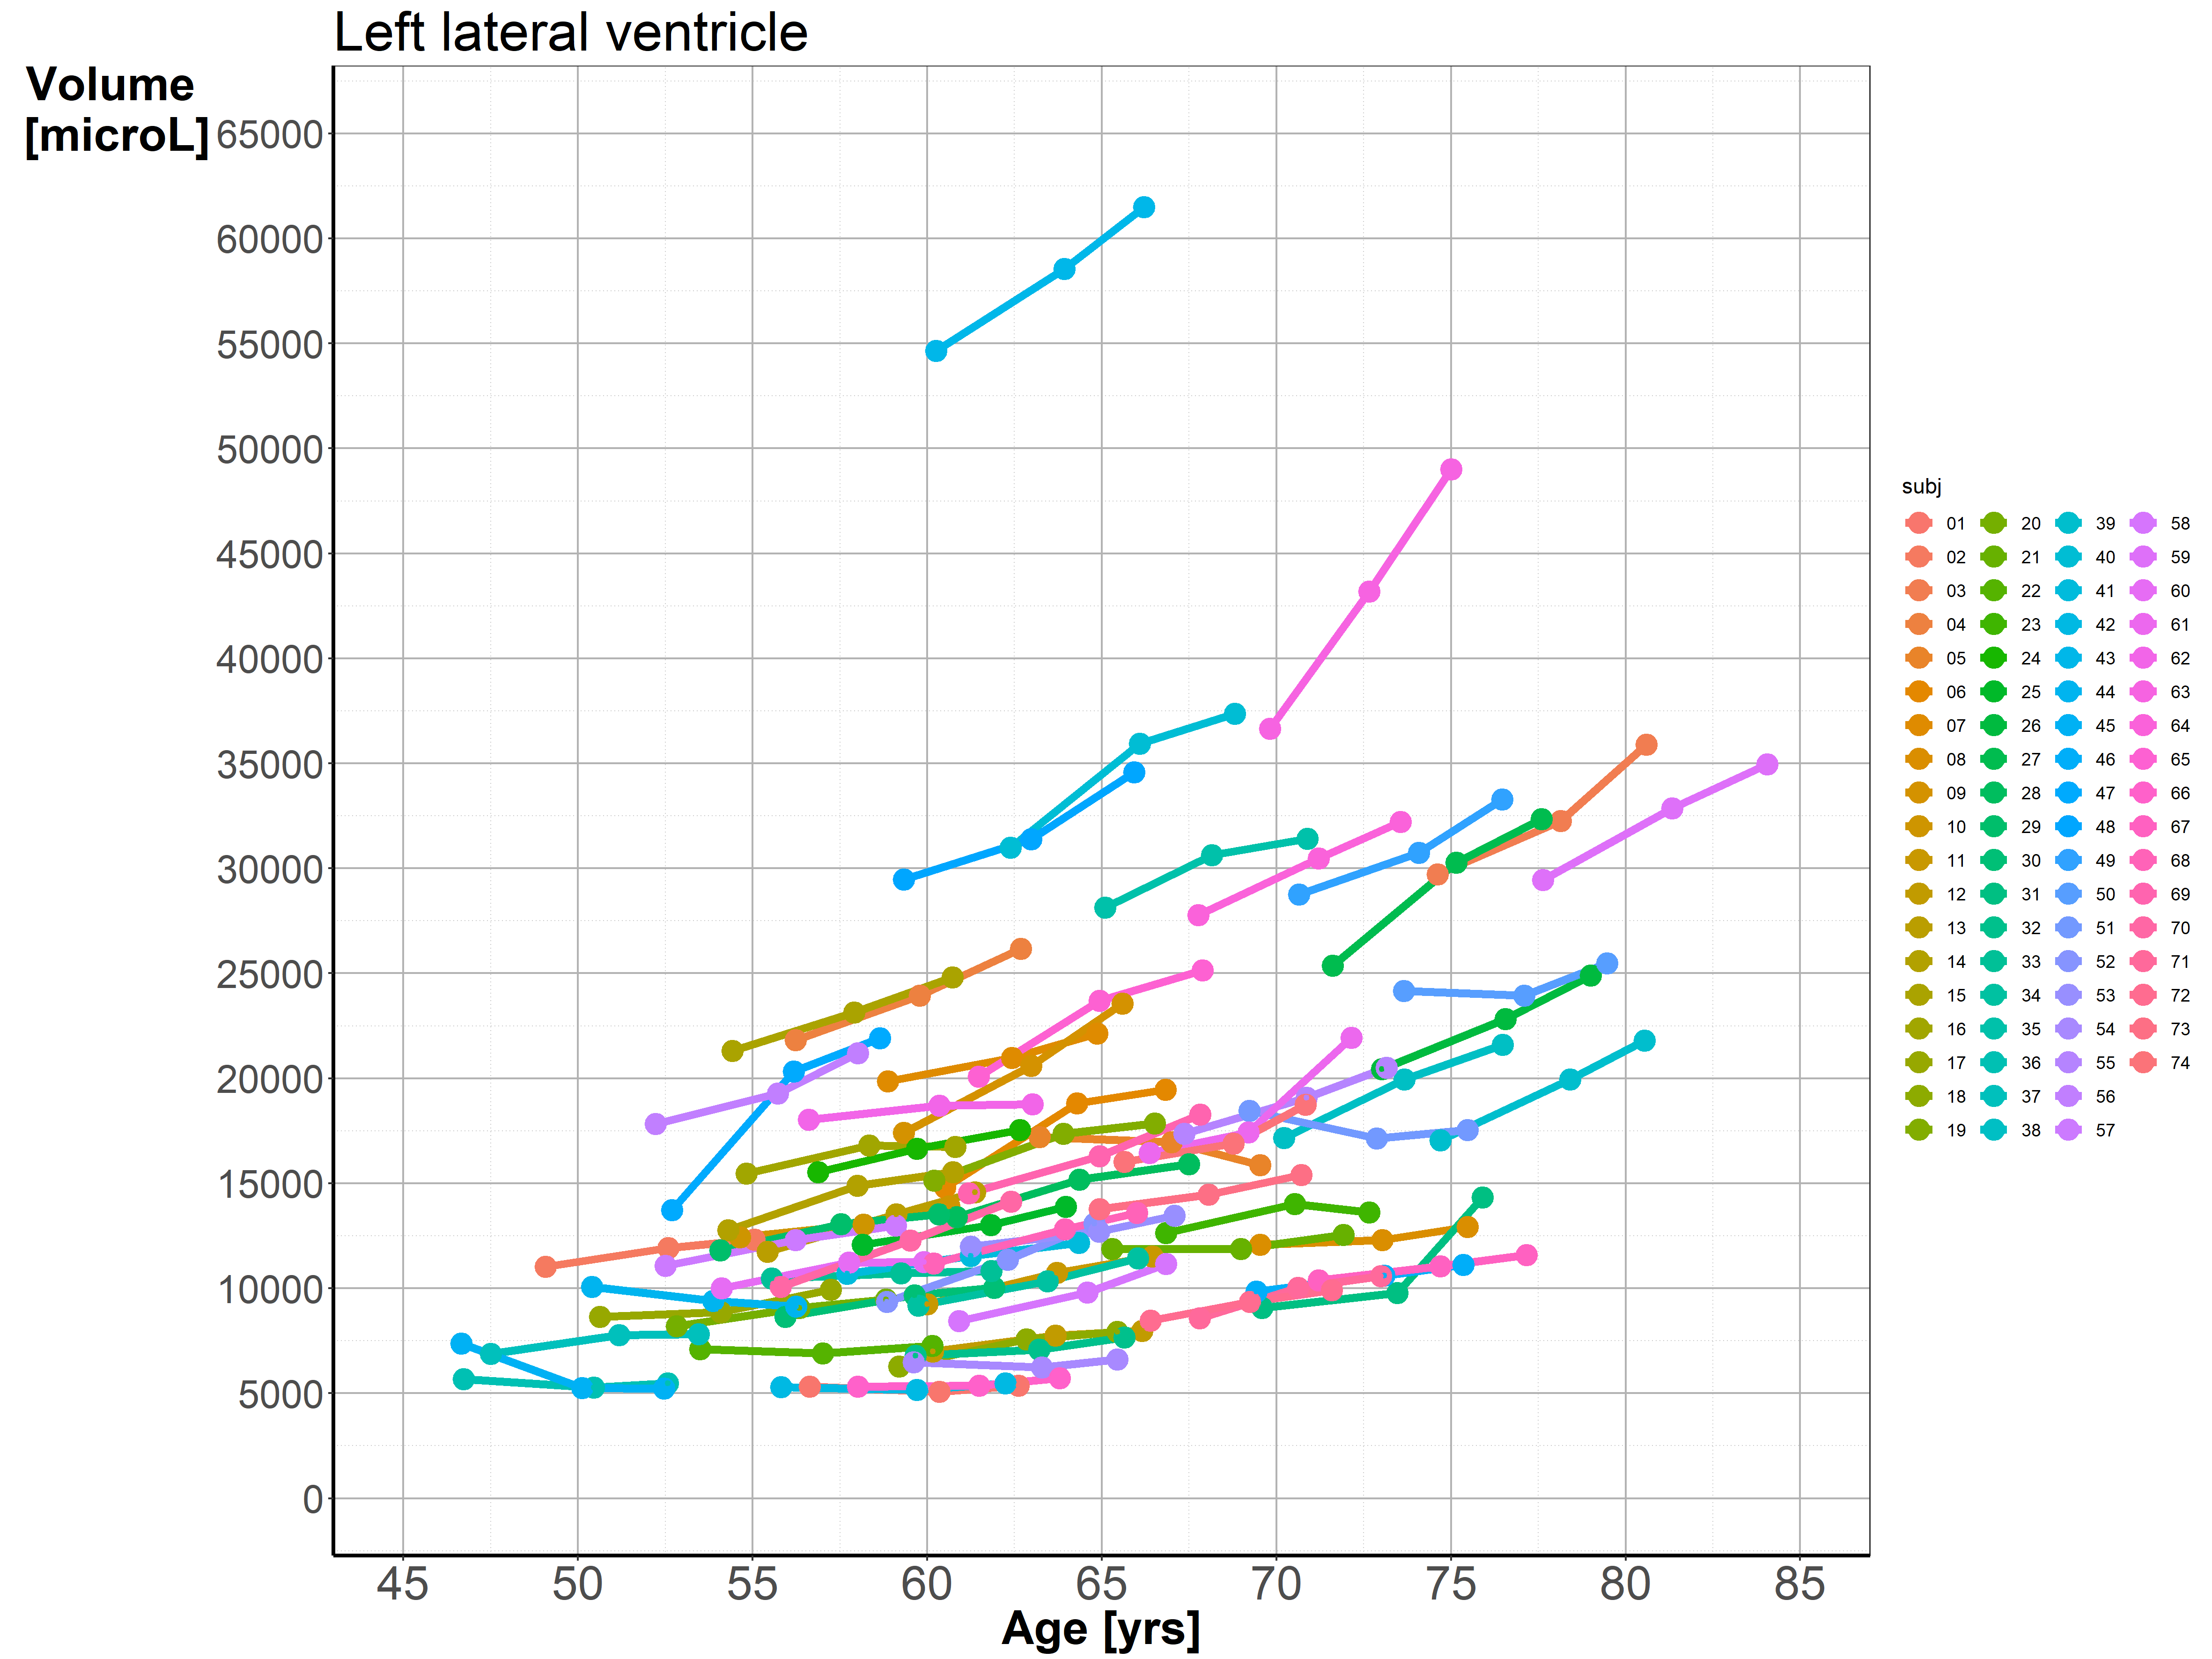

In [31]:
from IPython.display import Image
Image(filename='../figures/02_lvv_ri_rpy2_left_ventricle.png', width=900)

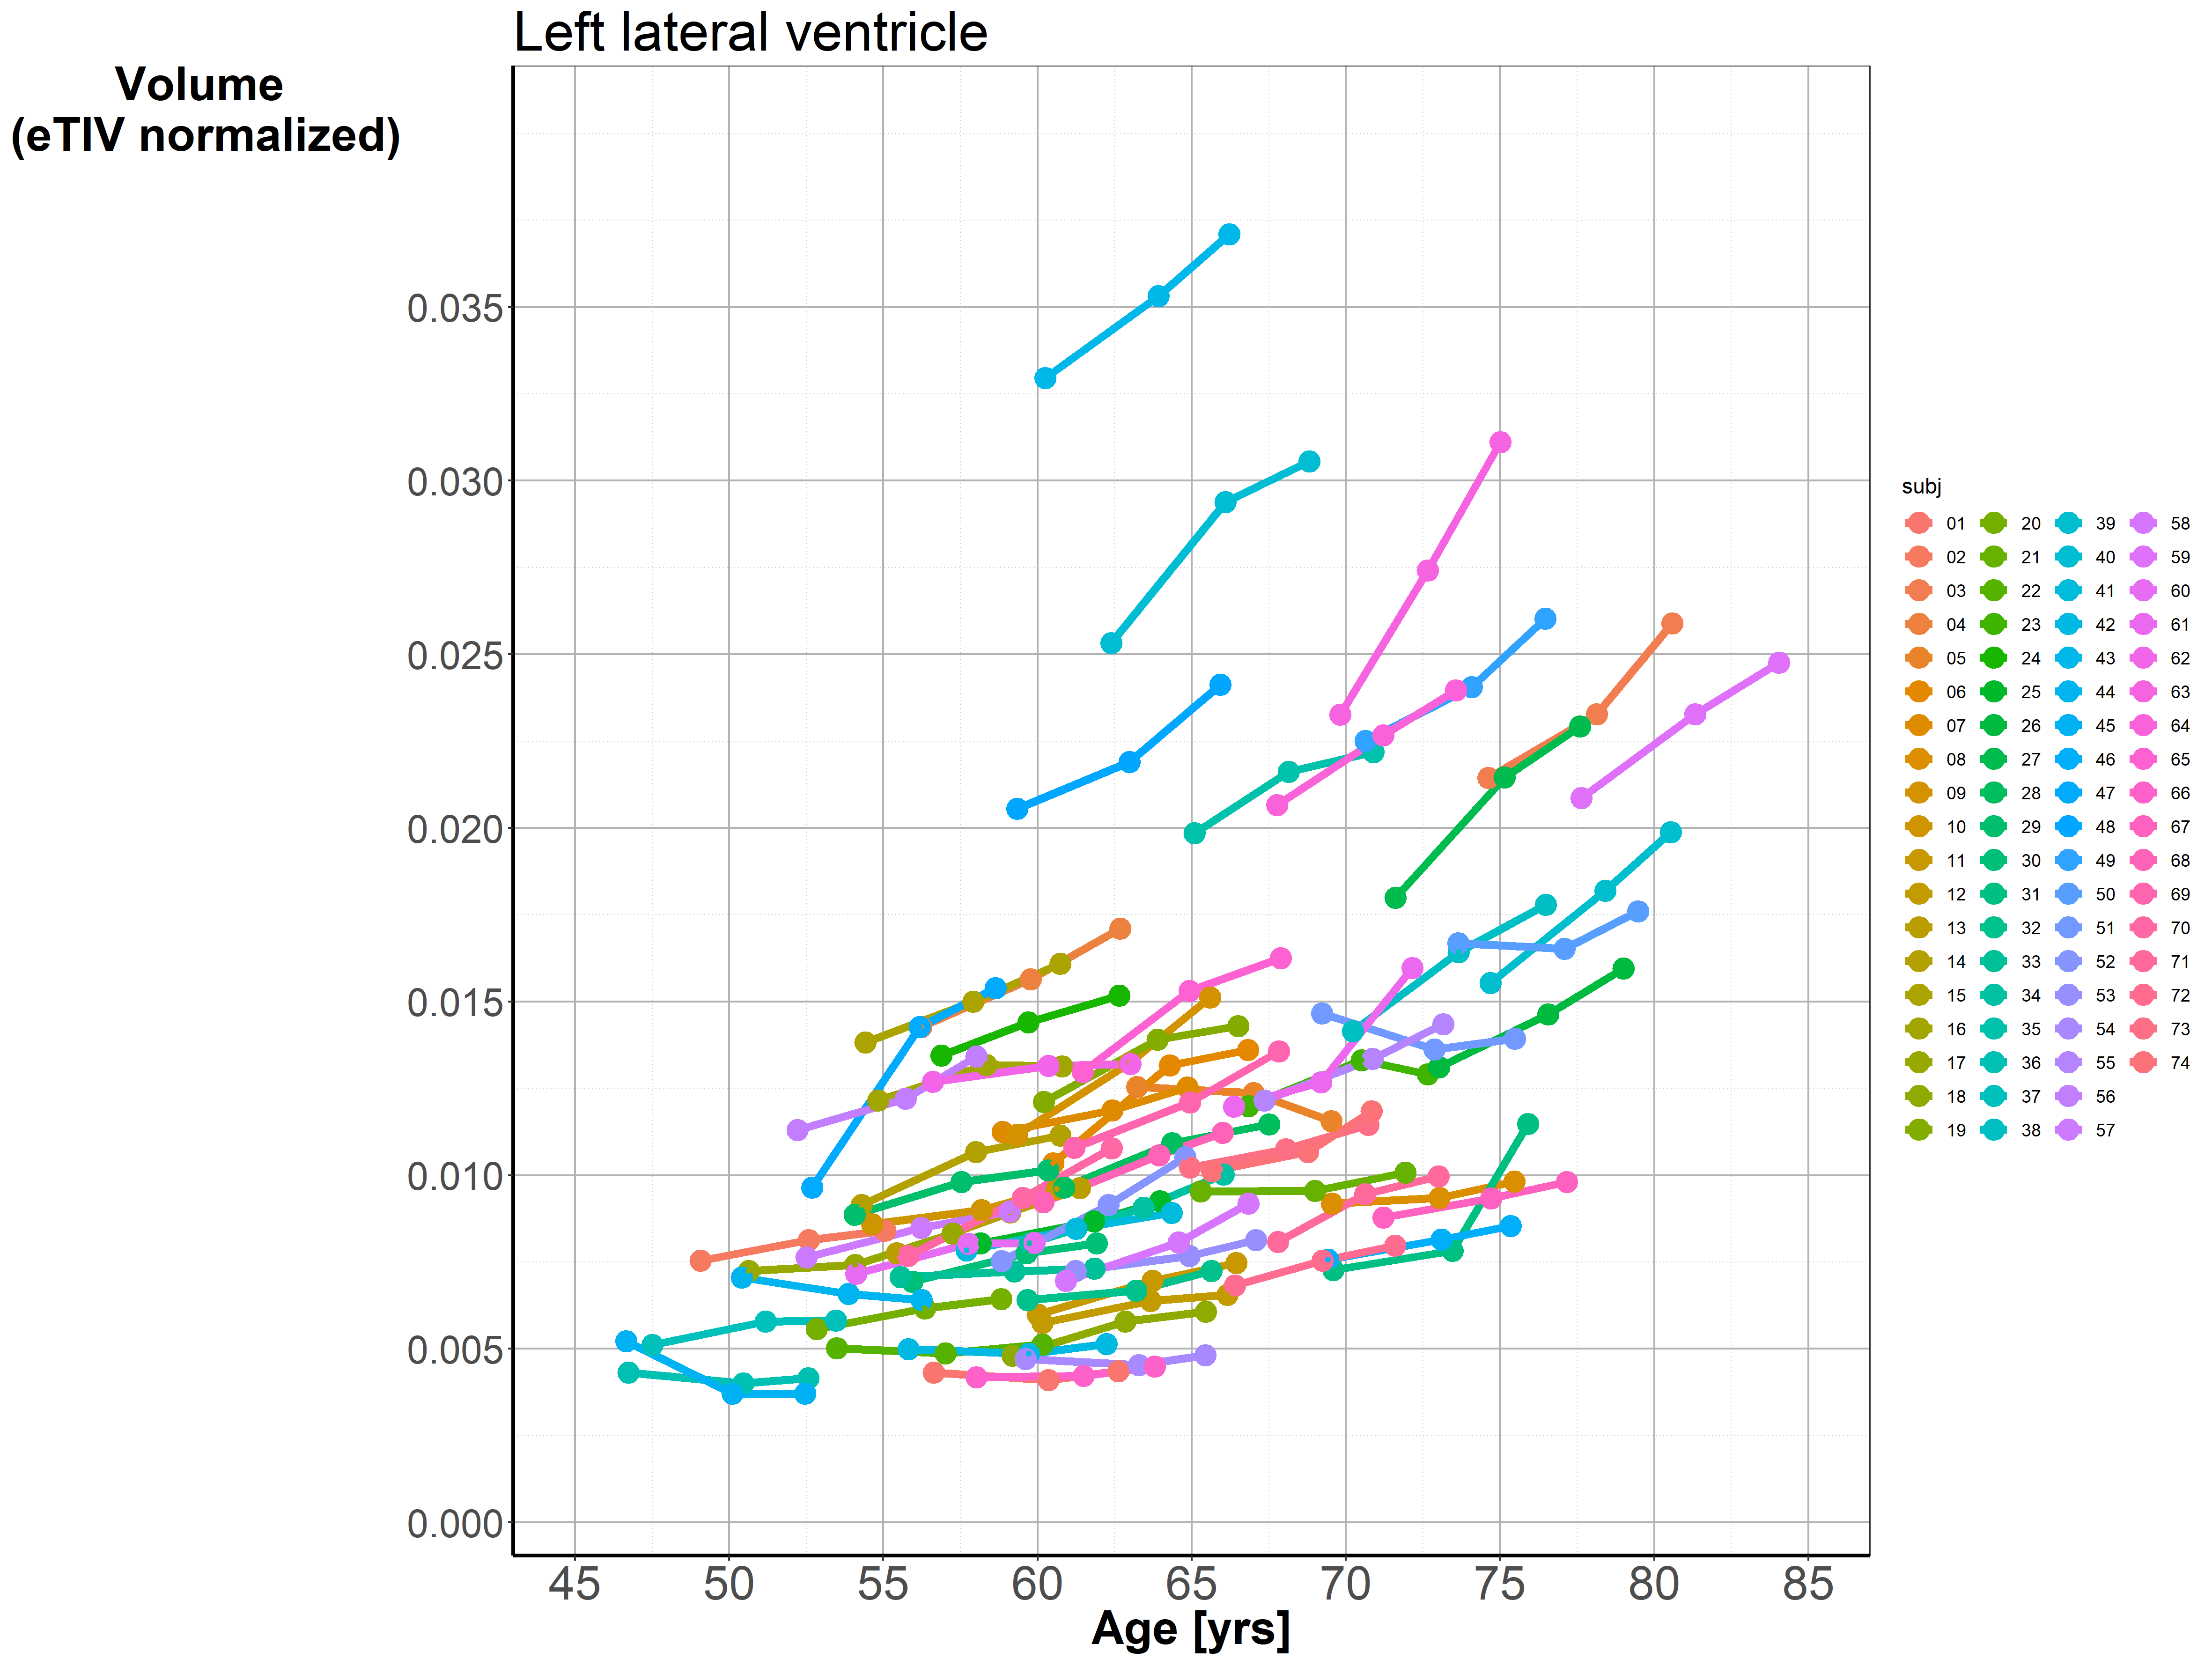

In [32]:
# Needs a run initialized with
# eTIV_NORMALIZED = True

from IPython.display import Image
Image(filename='../figures/02_lvv_ri_rpy2_left_ventricle_eTIV_norm.png', width=900)

In [33]:
%%R -i eTIV_NORMALIZED

NOR <- eTIV_NORMALIZED

# Right lateral ventricle

df <-  df.longR

title.1.R <- "Right lateral ventricle"

mytitle <- title.1.R

if (NOR) {
g12 <- ggplot(data = df, aes(x = Age, y = Volume_eTIVnorm, group = subj, colour = factor(subj))) + geom_line(size=2)
} else {
g12 <- ggplot(data = df, aes(x = Age, y = Volume, group = subj, colour = factor(subj))) + geom_line(size=2)
}
g12 <- g12 + scale_colour_discrete(name  ="subj") + geom_point(pch=19, size = 5)
myX <- scale_x_continuous(limits = c(45, 85), breaks = seq(45, 85, 5), name = "Age [yrs]")

if (NOR) {
myY <- scale_y_continuous(limits = c(0.001, 0.040), breaks = seq(0, 0.035, 0.005), name = "Volume \n(eTIV normalized)")
} else {
myY <- scale_y_continuous(limits = c(500, 65000), breaks = seq(0, 65000, 5000), name = "Volume\n [microL]") 
}
 
g12 <- g12 + geom_point(size = 1.0) + theme_bw() + myX + myY
g12 <- g12 + labs(title = mytitle, fontsize = 32)
# Set title to twice the base font size
g12 <- g12 + theme(plot.title = element_text(size = rel(2.0)))
g12 <- g12 + theme(axis.line = element_line(size = 1, colour = "black", linetype = "solid"))
g12 <- g12 + theme(axis.text = element_text(size = rel(1.5)))
g12 <- g12 + theme(axis.title.y = element_text(size = rel(1.8), angle = 0))
g12 <- g12 + theme(axis.title.x = element_text(size = rel(1.8), angle = 0))
g12 <- g12 + theme(panel.grid.major = element_line(colour = "gray70"))
g12 <- g12 + theme(panel.grid.minor = element_line(colour = "gray80", linetype = "dotted"))
g12 <- g12 + theme(plot.background = element_rect(fill = "white"))

g12 <- g12 + theme(axis.text.x=element_text(size=24), axis.title.x=element_text(size=24,face="bold"))
g12 <- g12 + theme(axis.text.y=element_text(size=20), axis.title.y=element_text(size=24,face="bold"))
g12 <- g12 + theme(plot.title = element_text(size=28))

if (NOR) {
ggsave("../figures/02_lvv_ri_rpy2_right_ventricle_eTIV_norm.pdf", width = 40, height = 30, units = "cm")
ggsave("../figures/02_lvv_ri_rpy2_right_ventricle_eTIV_norm.png", width = 40, height = 30, units = "cm")
} else {
ggsave("../figures/02_lvv_ri_rpy2_right_ventricle.pdf", width = 40, height = 30, units = "cm")
ggsave("../figures/02_lvv_ri_rpy2_right_ventricle.png", width = 40, height = 30, units = "cm")
}

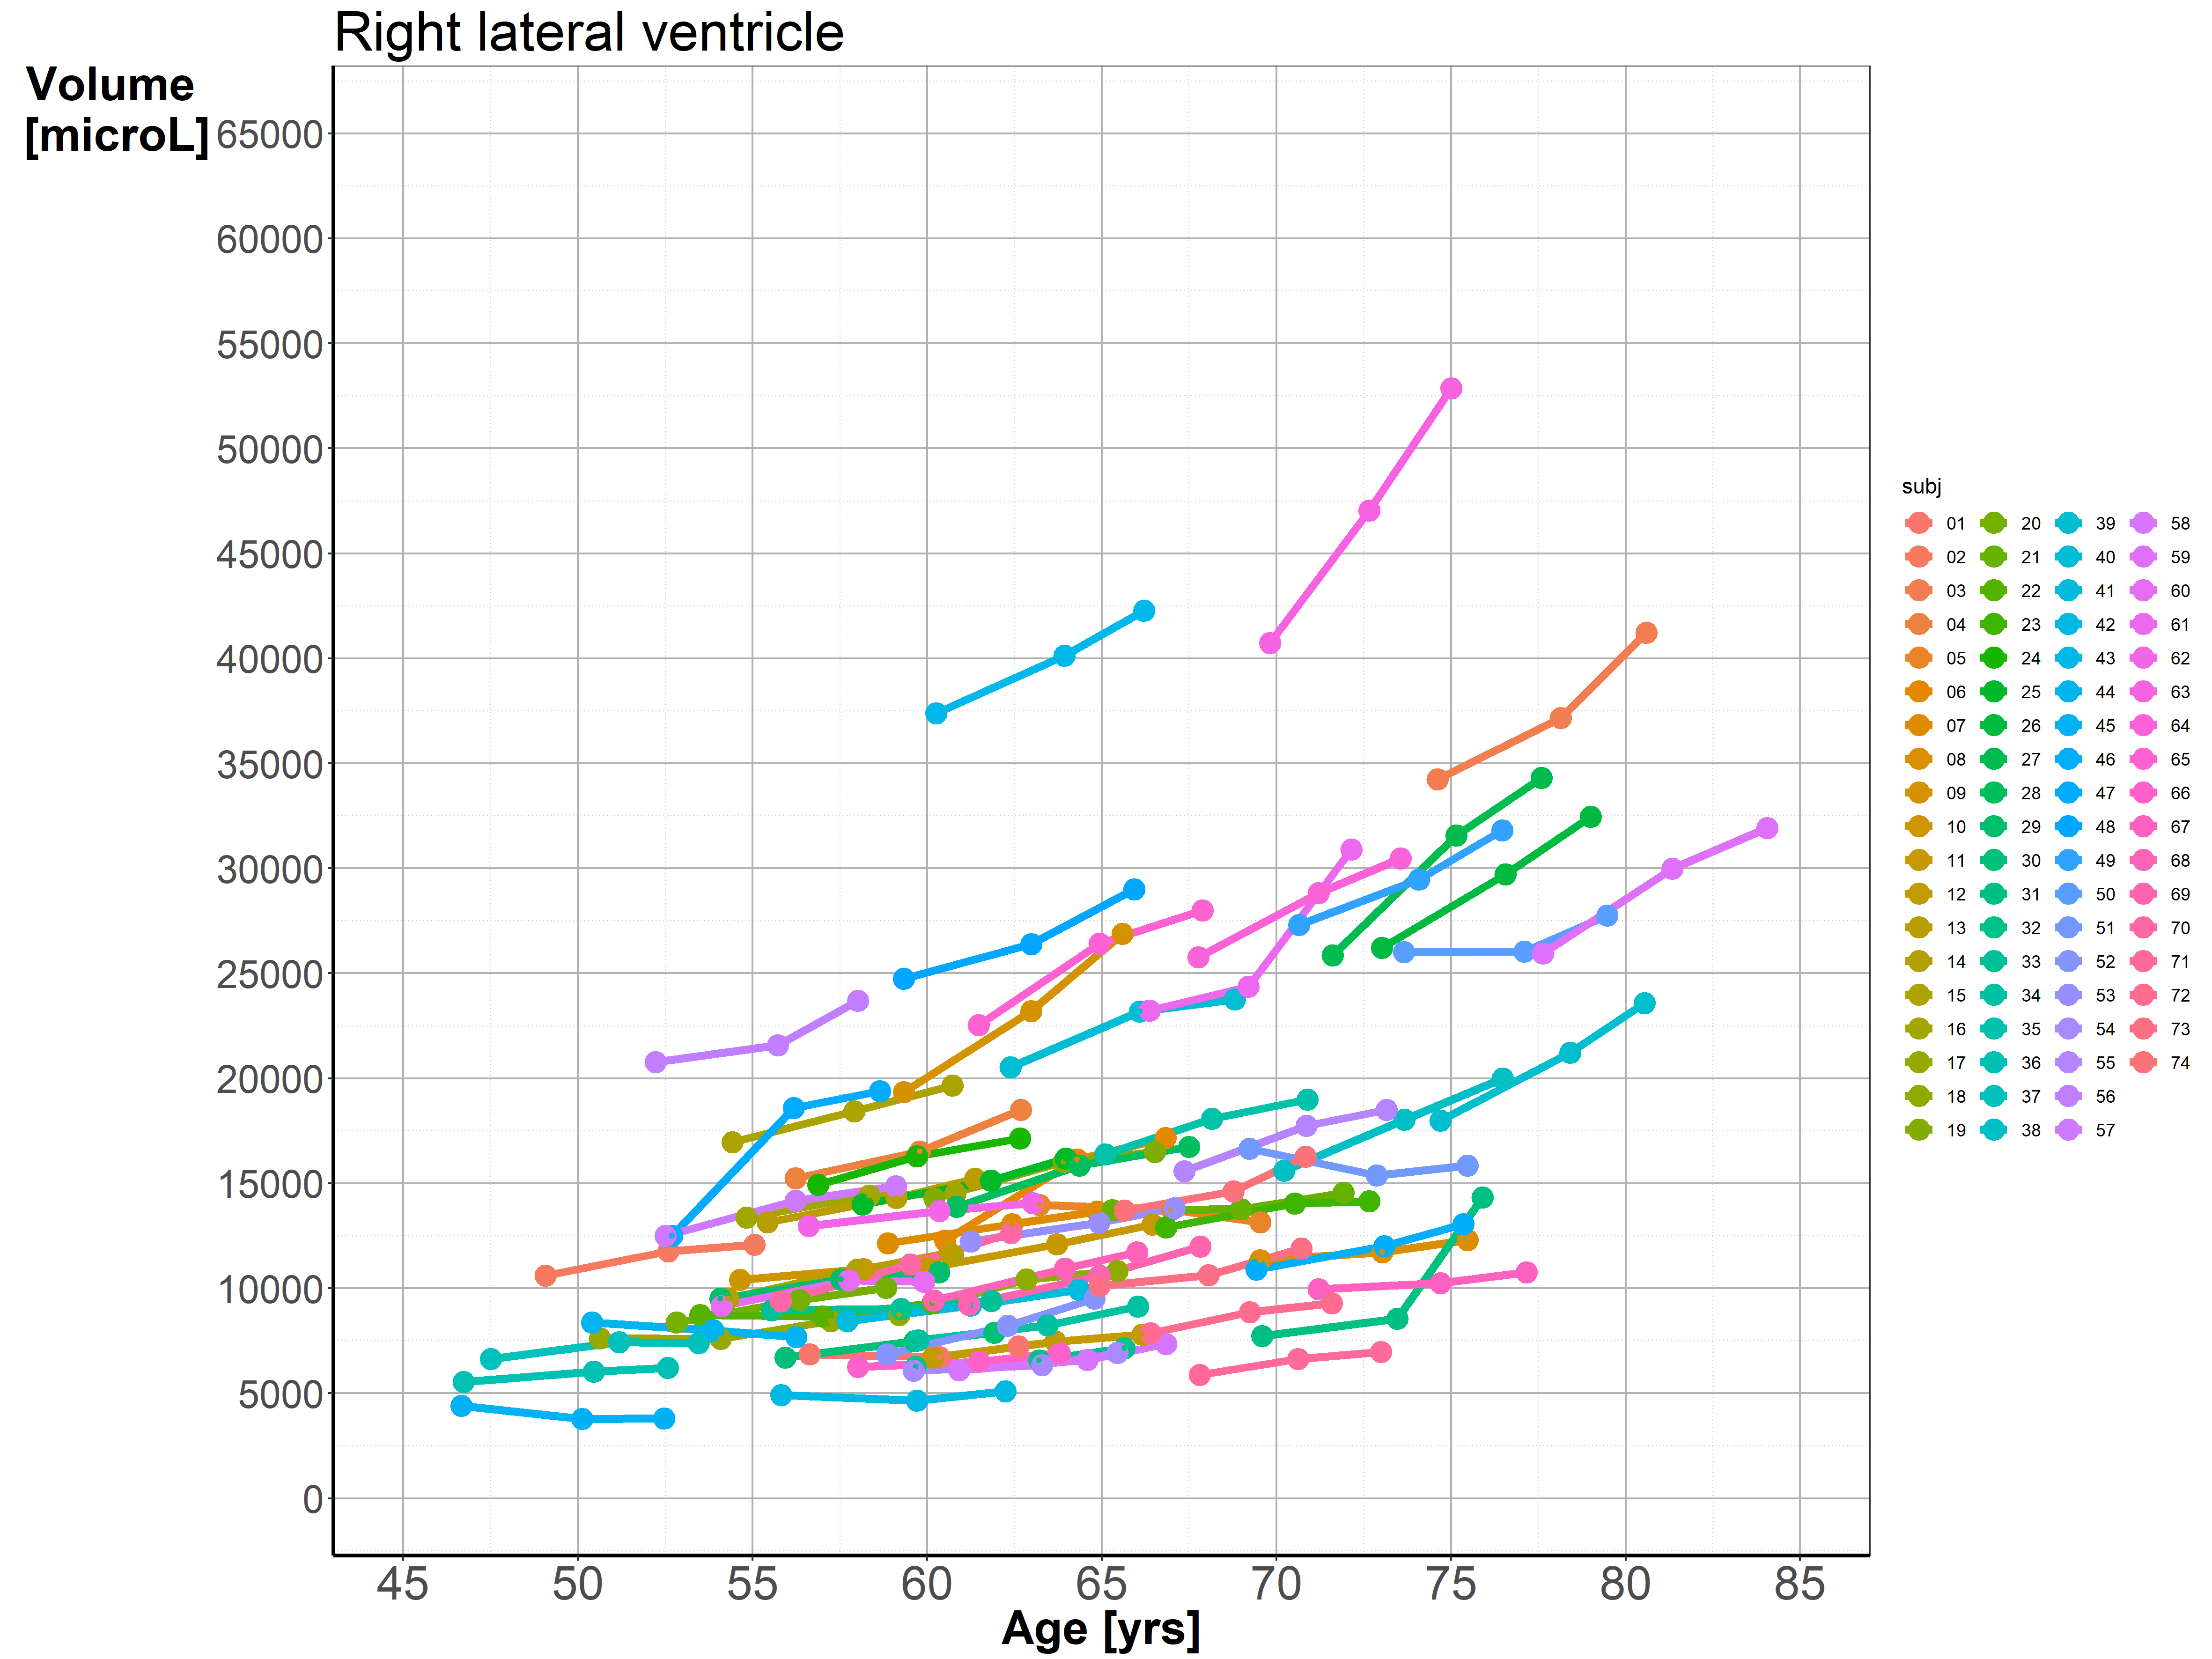

In [34]:
# %R plot(g12)
Image(filename='../figures/02_lvv_ri_rpy2_right_ventricle.png', width=900)

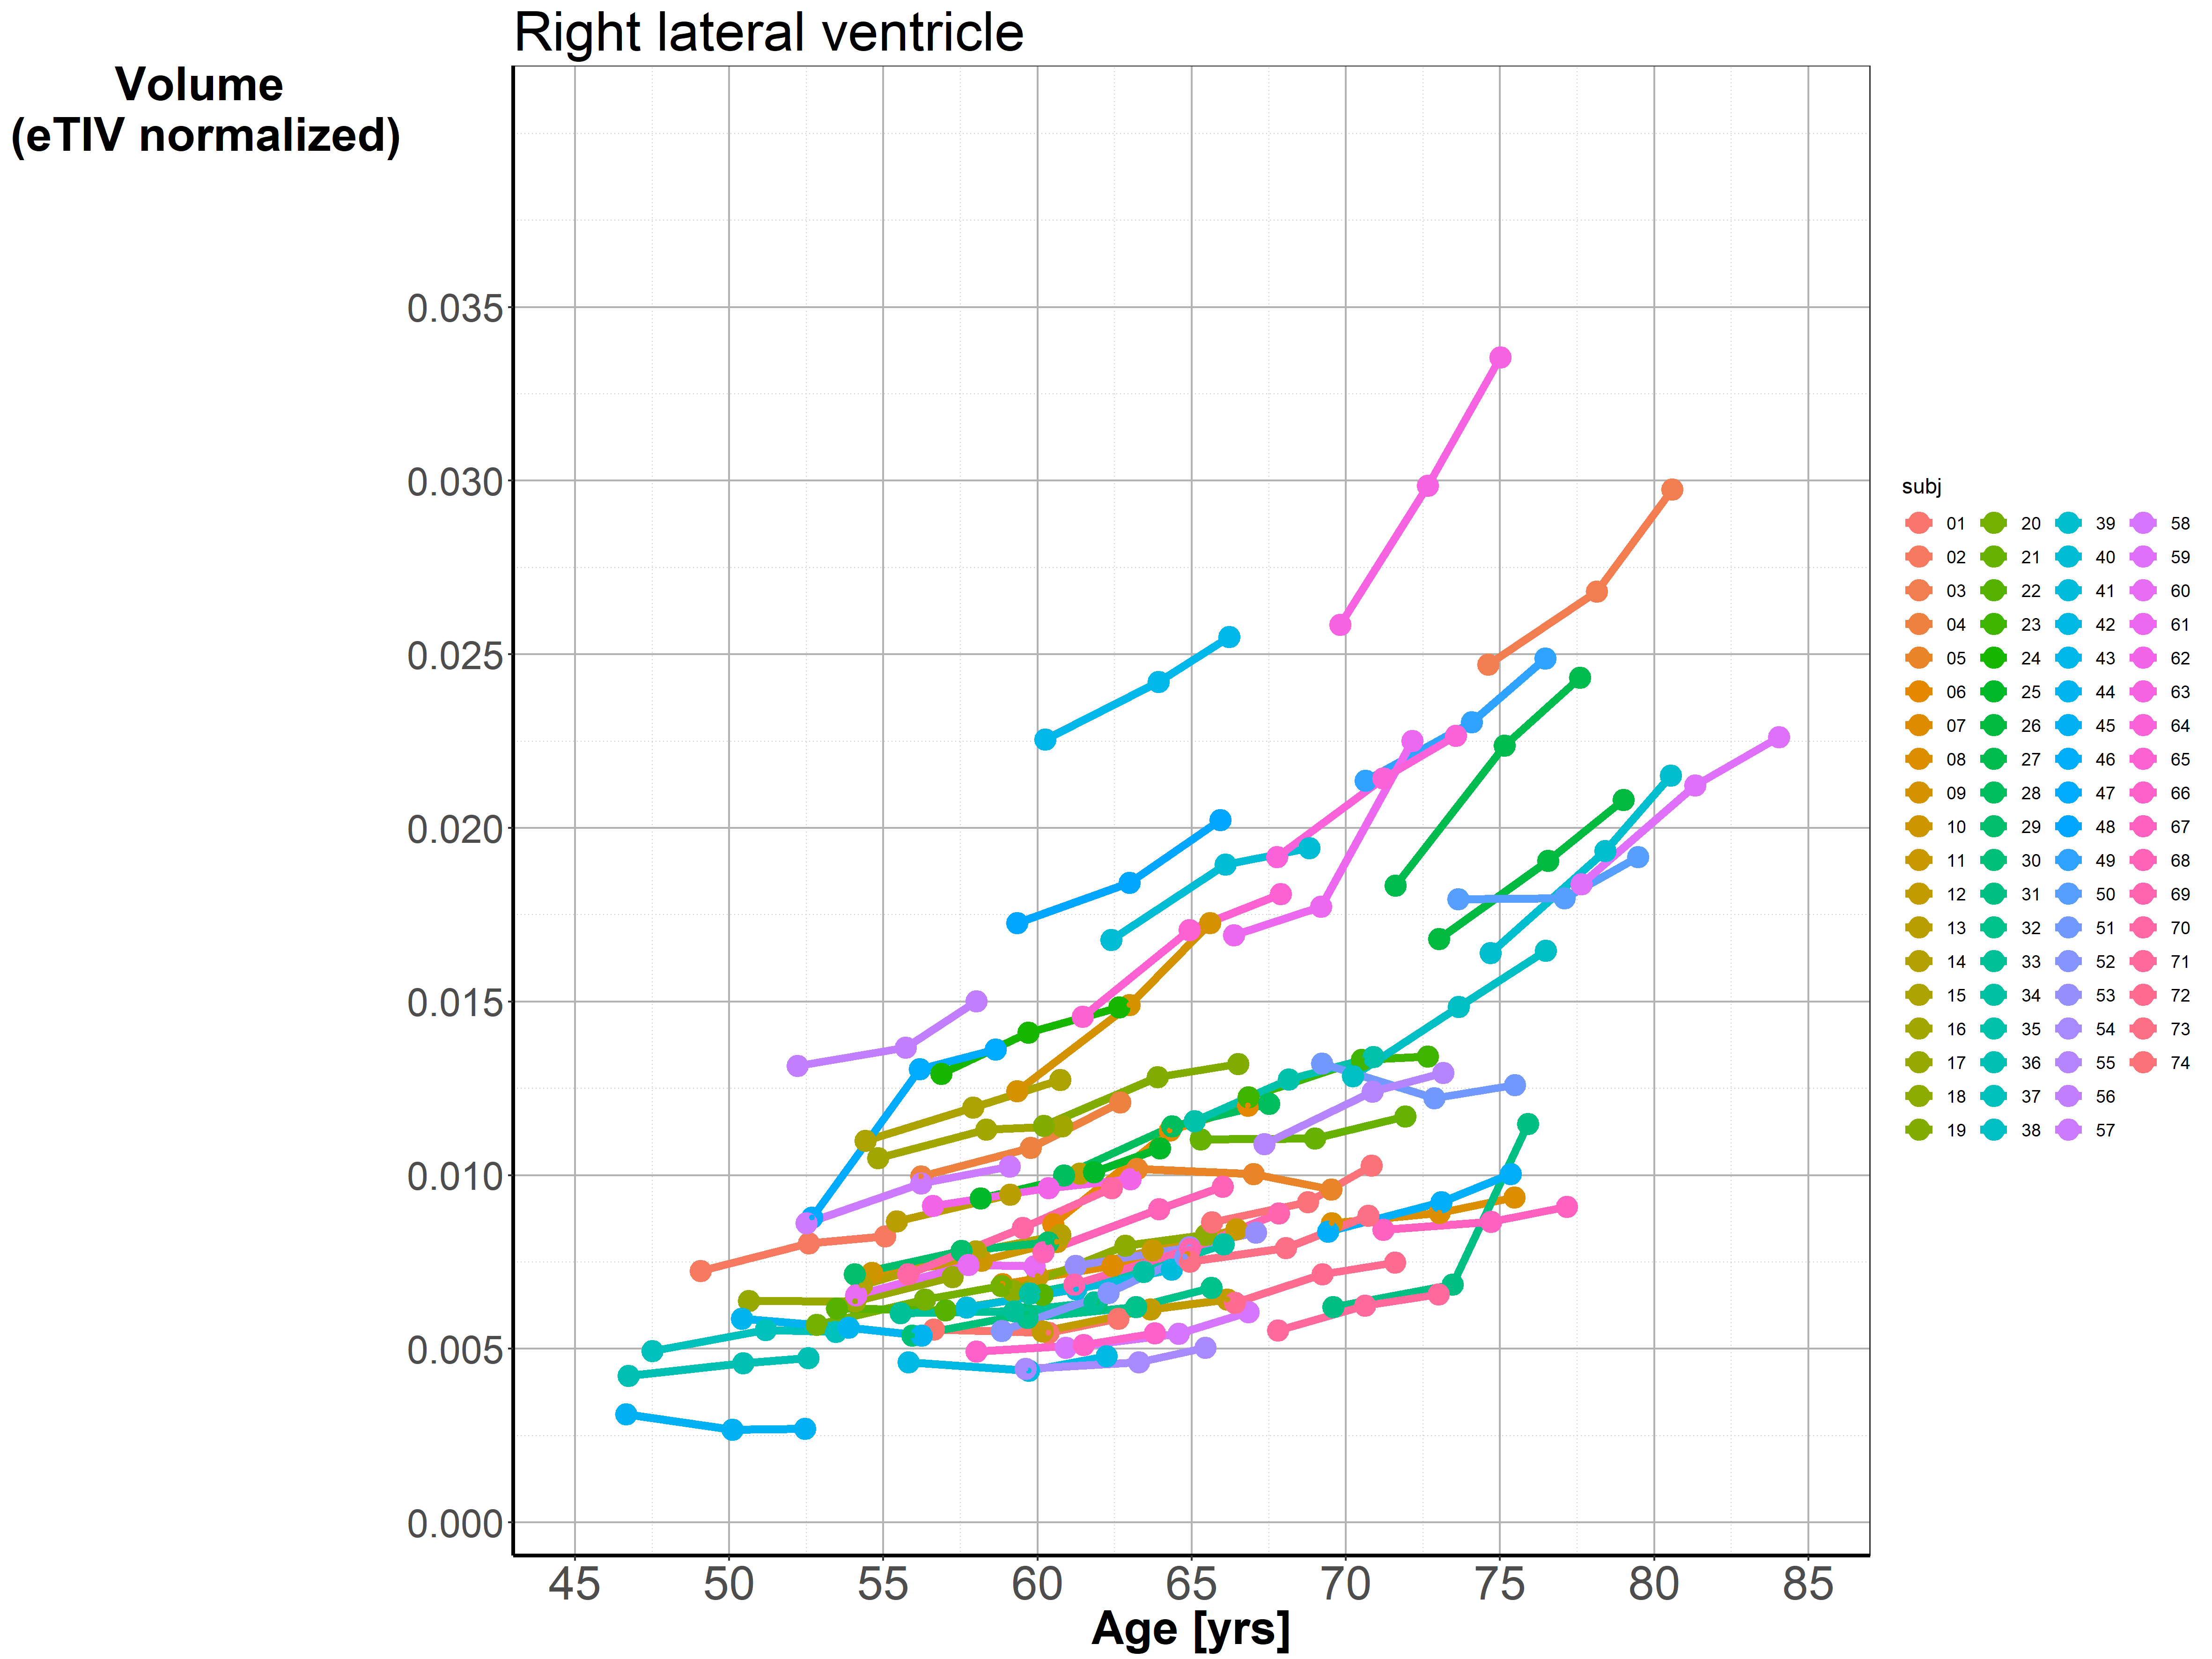

In [35]:
# Needs a run initialized with
# eTIV_NORMALIZED = True

Image(filename='../figures/02_lvv_ri_rpy2_right_ventricle_eTIV_norm.png', width=900)

In [36]:
%%R -i eTIV_NORMALIZED

NOR <- eTIV_NORMALIZED

df <-  df.longL
mylm <- lm.1.L
mylmer <- lmer.1.L
mytitle <- title.1.L

if (NOR) {
g21 <- ggplot(data = df, aes(x = Age, y = Volume_eTIVnorm, group = subj, colour = factor(subj))) + geom_line(size=1)
} else {
g21 <- ggplot(data = df, aes(x = Age, y = Volume, group = subj, colour = factor(subj))) + geom_line(size=1)
}
    
    
g21 <- g21 + scale_colour_discrete(name  ="subj") + geom_point(pch=19, size = 4)
myX <- scale_x_continuous(limits = c(45, 85), breaks = seq(45, 85, 5), name = "Age [yrs]")
if (NOR) {
myY <- scale_y_continuous(limits = c(0.001, 0.040), breaks = seq(0, 0.035, 0.005), name = "Volume \n(eTIV normalized)")
} else {
myY <- scale_y_continuous(limits = c(500, 65000), breaks = seq(0, 65000, 5000), name = "Volume\n [microL]")
}

g21 <- g21 + geom_point(size = 4.0) + theme_bw() + myX + myY
g21 <- g21 + geom_abline(intercept = a0.L, slope = a1.L, linetype = "dashed", size=2.0, colour = "red")
g21 <- g21 + geom_abline(intercept = beta0.L, slope = beta1.L, linetype = "solid", size=2.0, colour = "black")
g21 <- g21 + labs(title = mytitle, fontsize = 32)
# Set title to twice the base font size
g21 <- g21 + theme(plot.title = element_text(size = rel(1.7)))
g21 <- g21 + theme(axis.line = element_line(size = 1, colour = "black", linetype = "solid"))
g21 <- g21 + theme(axis.text = element_text(size = rel(1.2)))
g21 <- g21 + theme(axis.title.y = element_text(size = rel(1.5), angle = 0))
g21 <- g21 + theme(axis.title.x = element_text(size = rel(1.5), angle = 0))
g21 <- g21 + theme(legend.position="none")
g21 <- g21 + theme(panel.grid.major = element_line(colour = "gray70"))
g21 <- g21 + theme(panel.grid.minor = element_line(colour = "gray80", linetype = "dotted"))
g21 <- g21 + theme(plot.background = element_rect(fill = "white"))

g21 <- g21 + theme(axis.text.x=element_text(size=24), axis.title.x=element_text(size=24,face="bold"))
g21 <- g21 + theme(axis.text.y=element_text(size=20), axis.title.y=element_text(size=24,face="bold"))
g21 <- g21 + theme(plot.title = element_text(size=28))

# Focus on individual trajectories; first fit a simple linear model to each trajectory
n <- length(b0i.L)
for (i in 1:n) {
  myx <-  df$Age[df$Wave==1][i]
  myxend <- df$Age[df$Wave==3][i]
  myy <- (beta0.L + b0i.L[i]) + (beta1.L + b1i.L[i])*myx
  myyend <- (beta0.L + b0i.L[i]) + (beta1.L + b1i.L[i])*myxend
  g21 <- g21 + annotate("segment", x = myx, xend = myxend, y = myy, yend = myyend, colour = "black", size = 0.3)
}

if (NOR) {
ggsave("../figures/02_lvv_ri_rpy2_lmer_left_ventricle_eTIV_norm.pdf", width = 40, height = 30, units = "cm")
ggsave("../figures/02_lvv_ri_rpy2_lmer_left_ventricle_eTIV_norm.png", width = 40, height = 30, units = "cm")
} else {
ggsave("../figures/02_lvv_ri_rpy2_lmer_left_ventricle.pdf", width = 40, height = 30, units = "cm")
ggsave("../figures/02_lvv_ri_rpy2_lmer_left_ventricle.png", width = 40, height = 30, units = "cm")
}

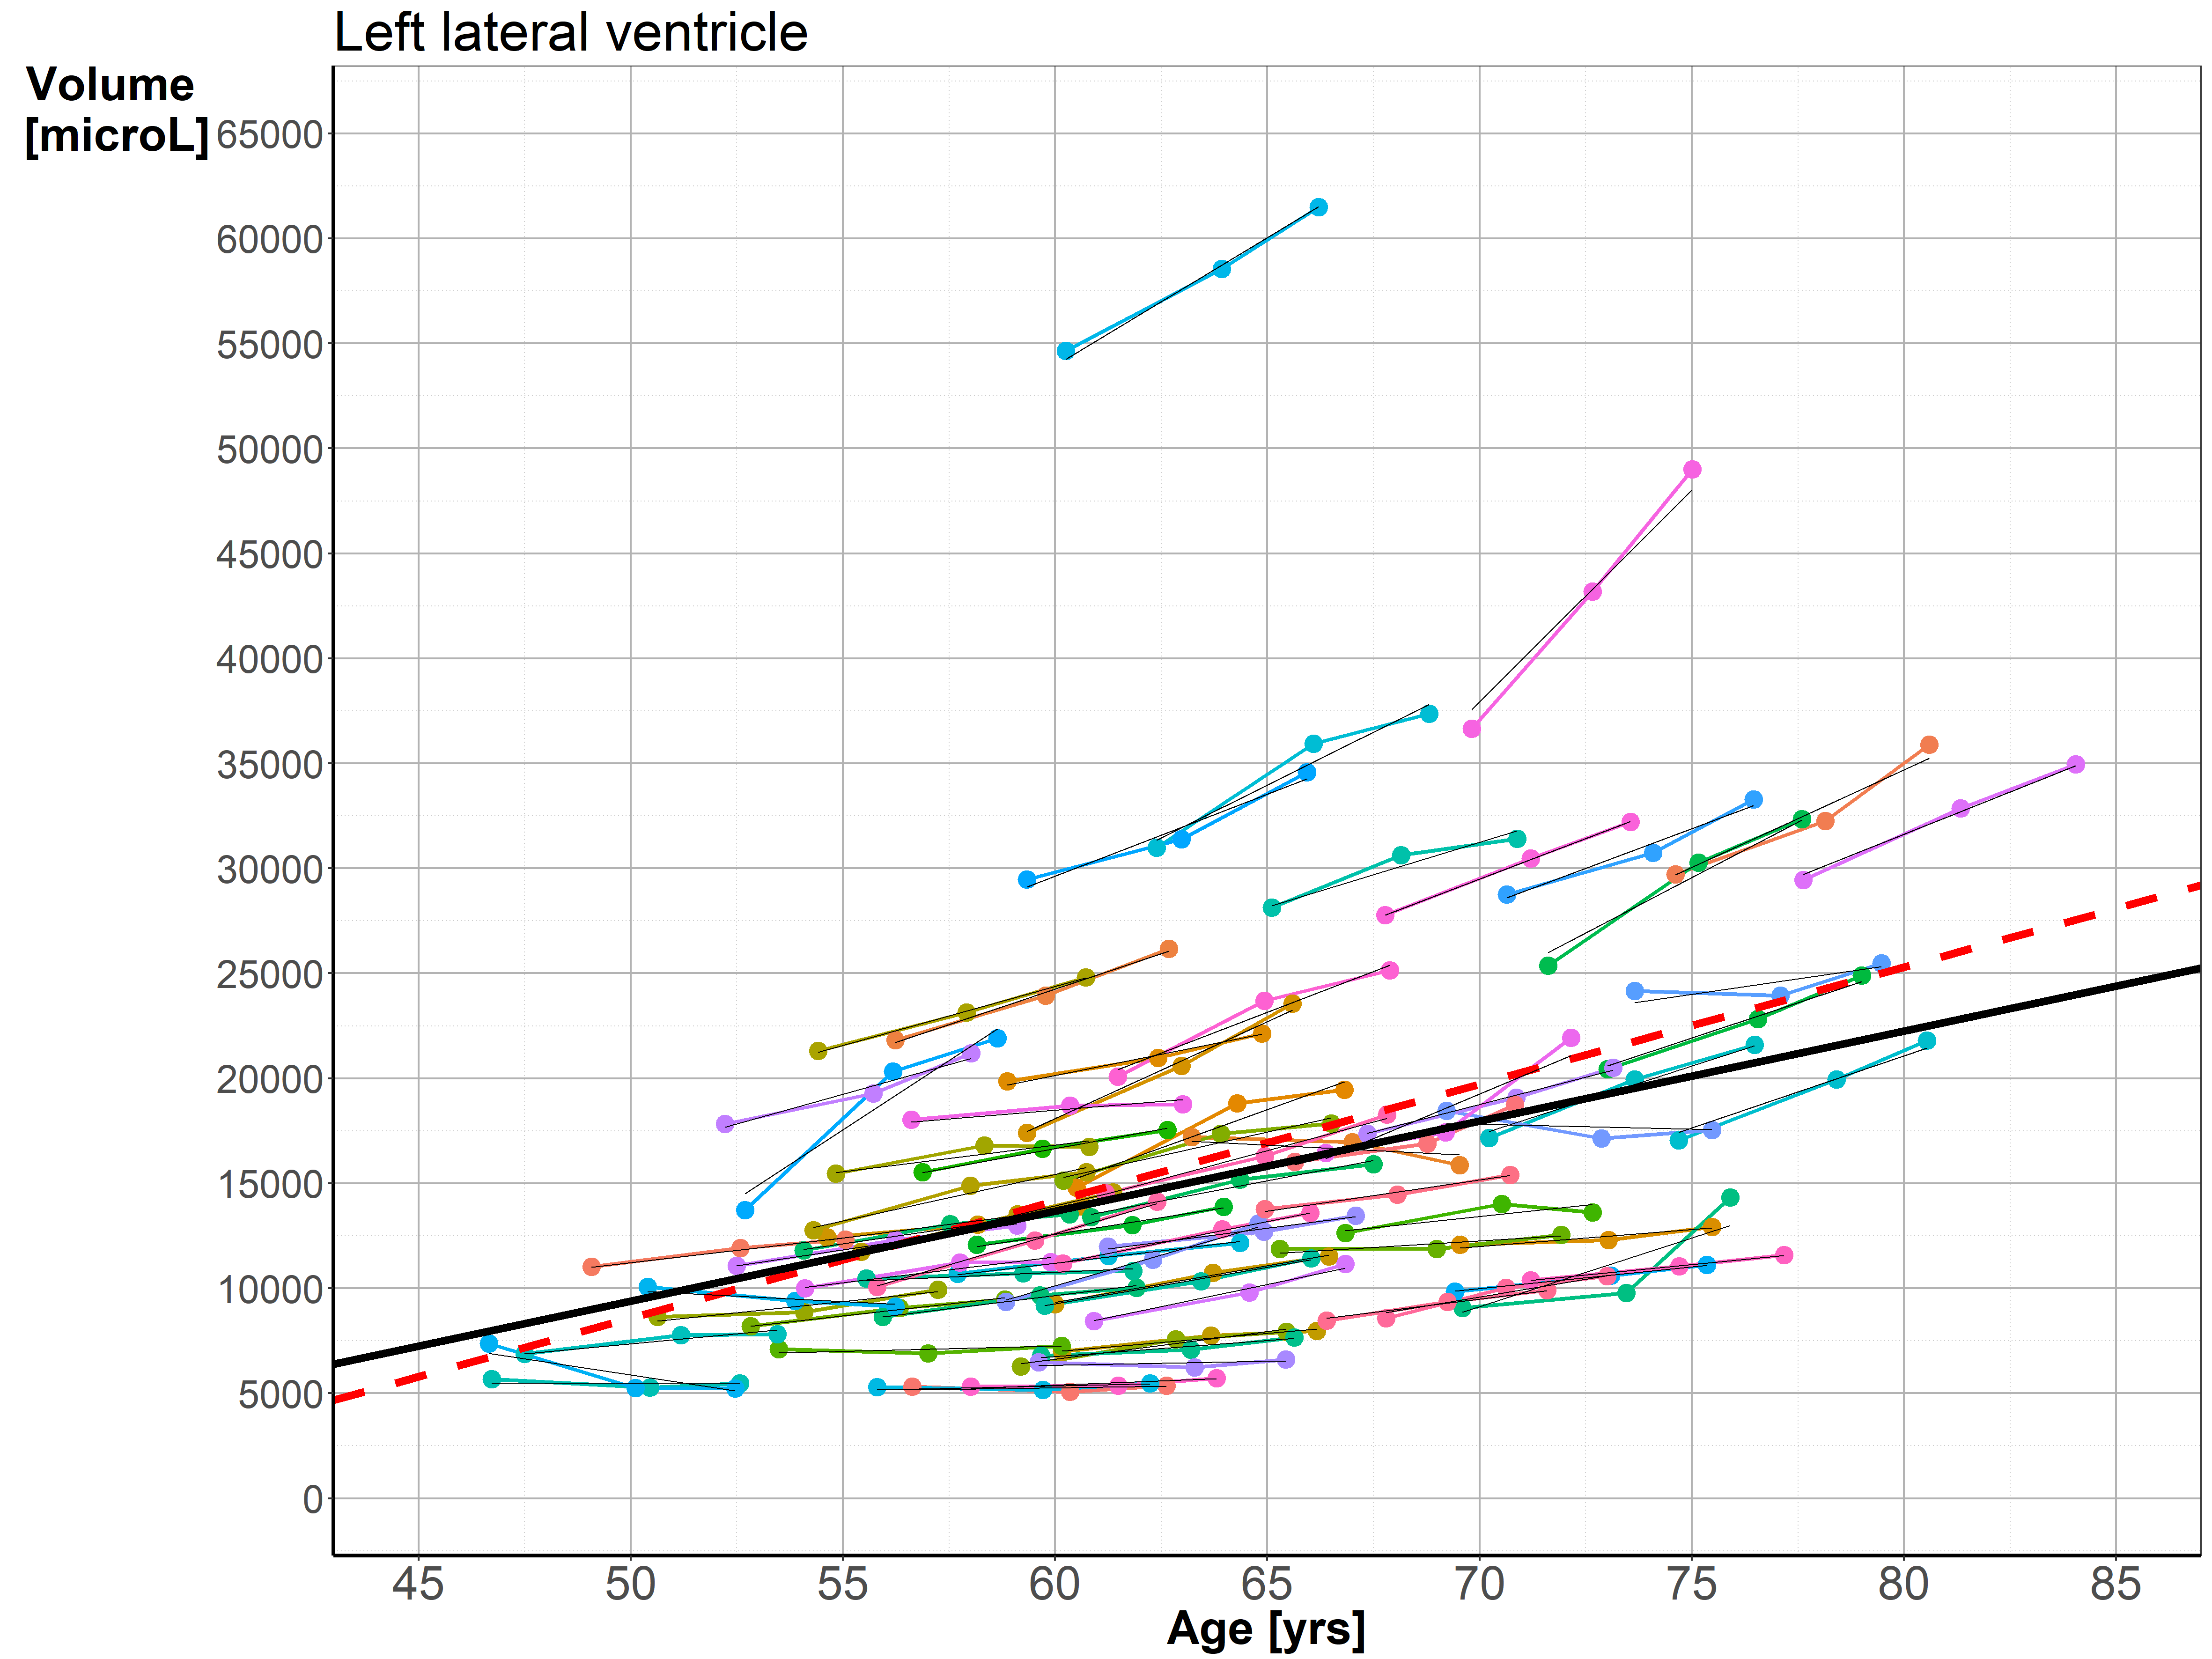

In [37]:
# %R print(g21)
Image(filename='../figures/02_lvv_ri_rpy2_lmer_left_ventricle.png', width=900)

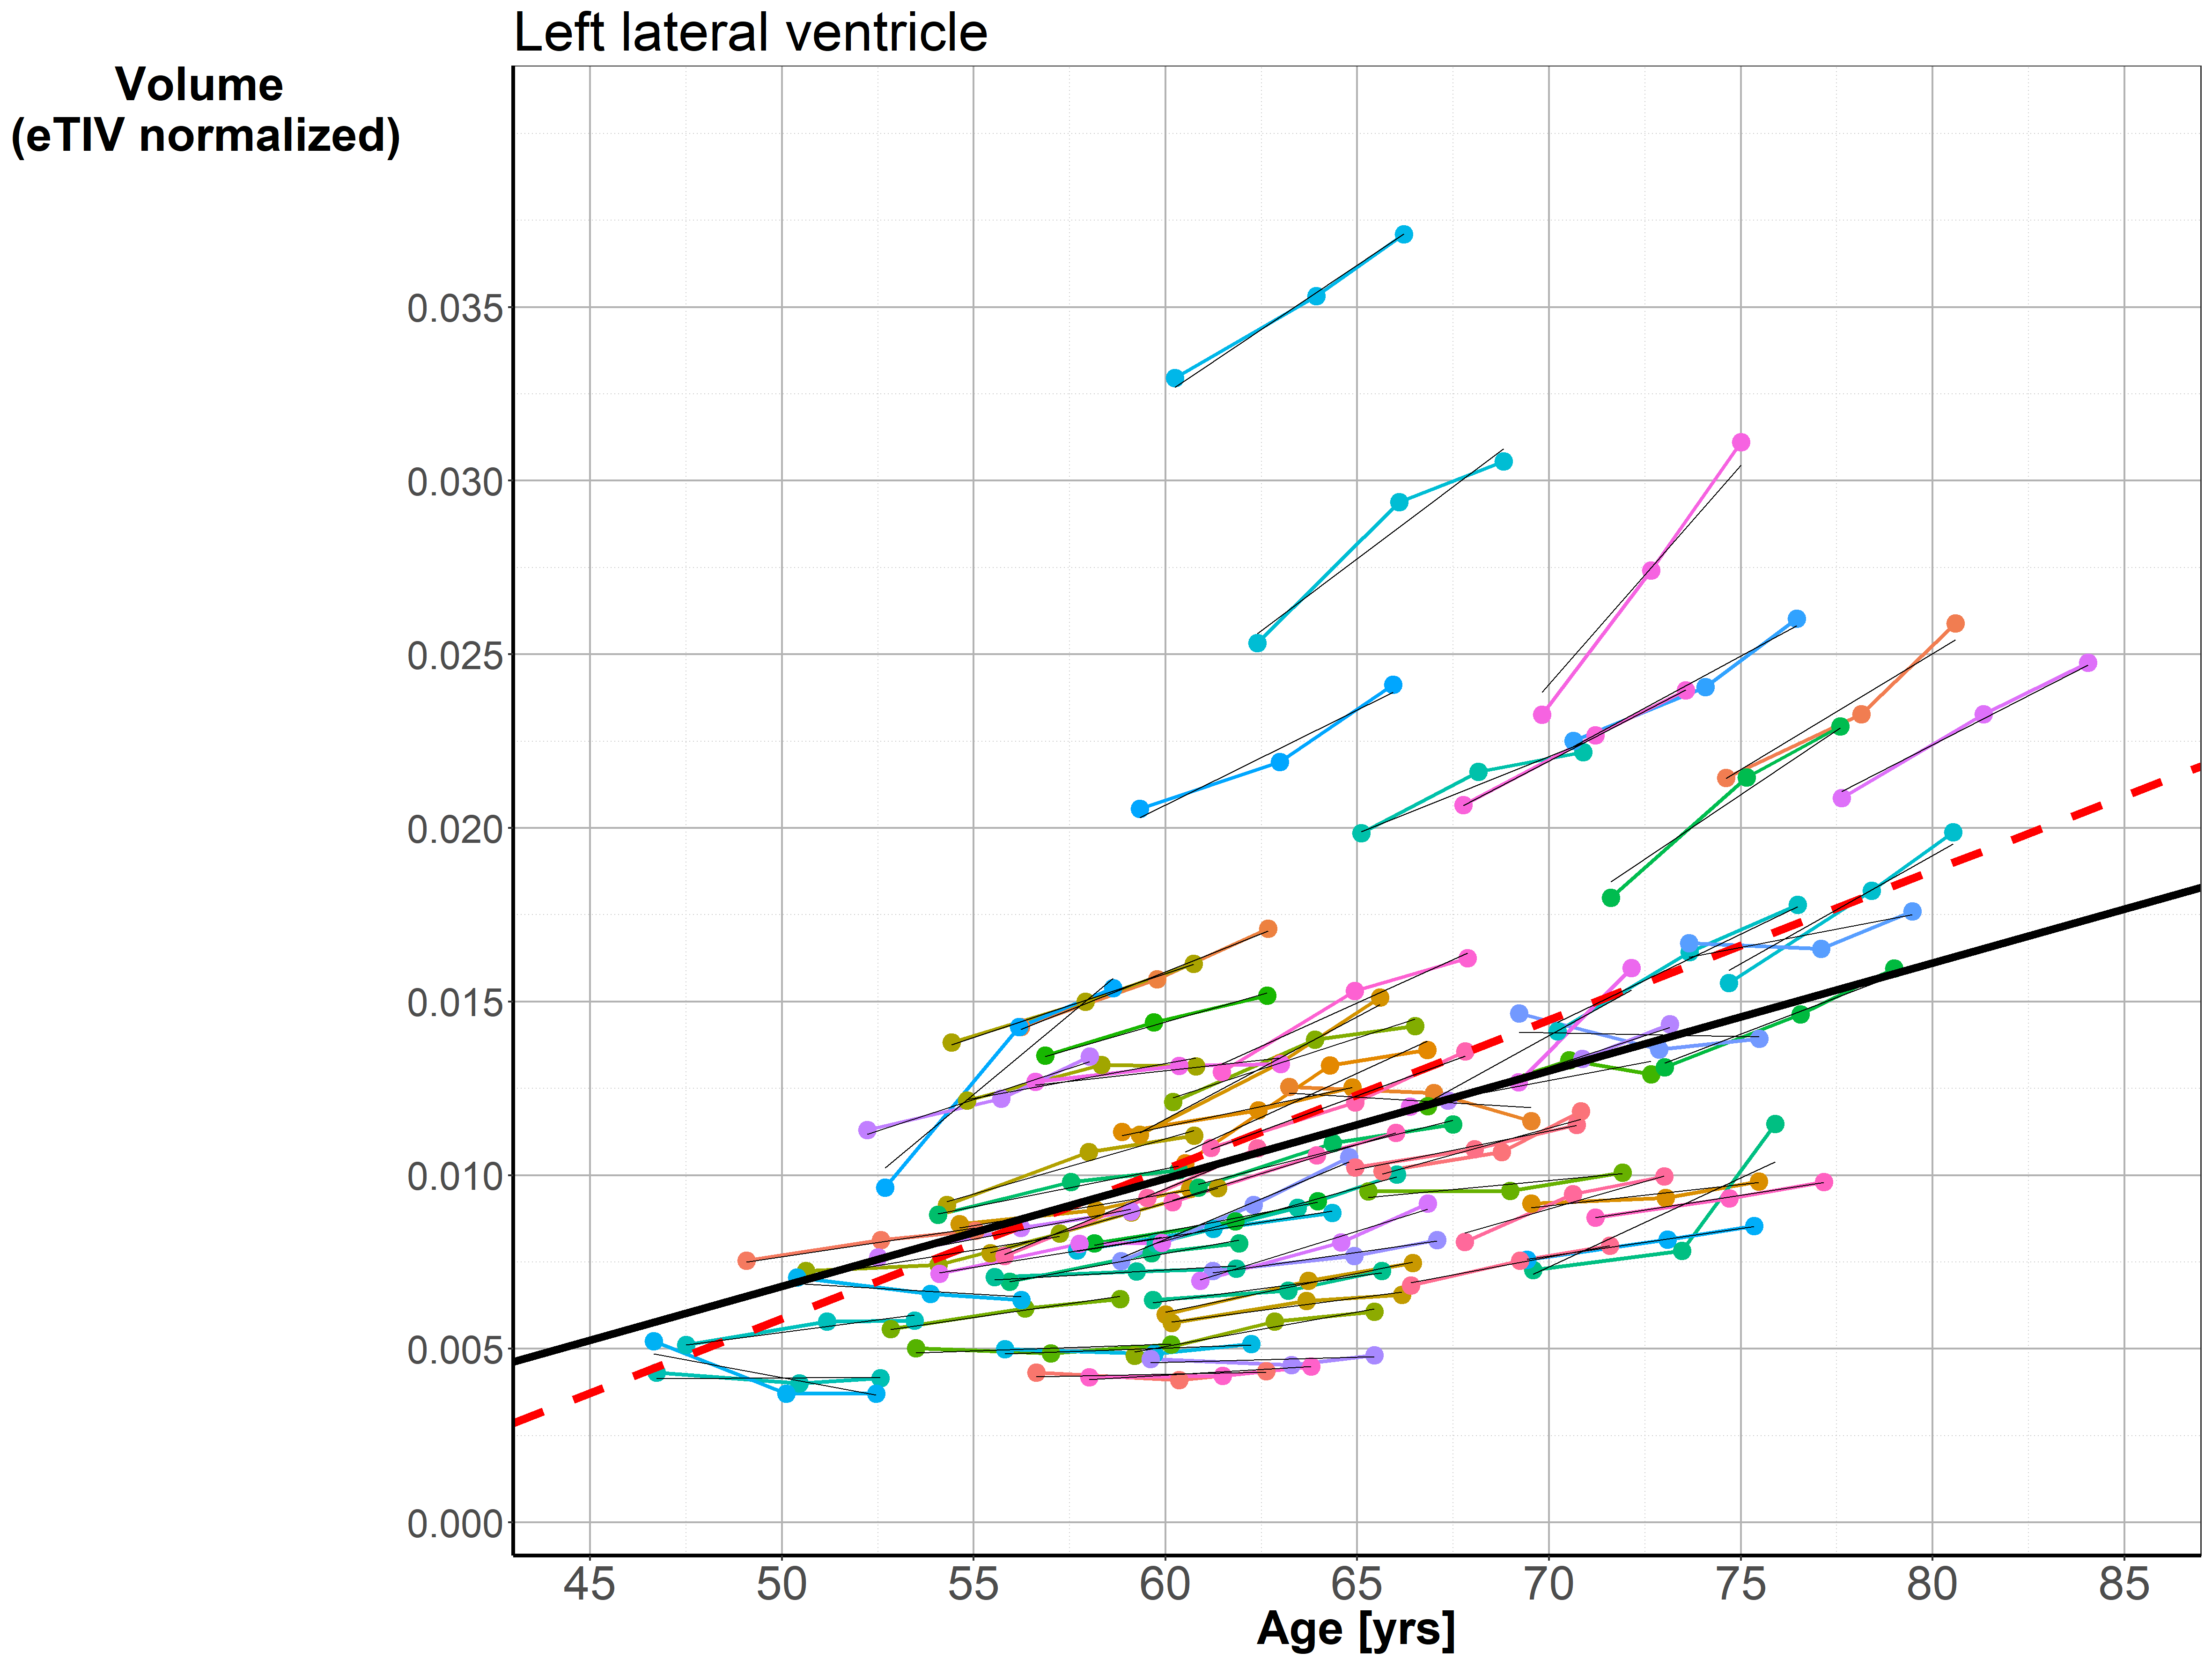

In [38]:
# Needs a run initialized with
# eTIV_NORMALIZED = True

Image(filename='../figures/02_lvv_ri_rpy2_lmer_left_ventricle_eTIV_norm.png', width=900)

In [39]:
%%R -i eTIV_NORMALIZED

NOR <- eTIV_NORMALIZED


df <-  df.longR
mylm <- lm.1.R
mylmer <- lmer.1.R
mytitle <- title.1.R

if (NOR) {
g22 <- ggplot(data = df, aes(x = Age, y = Volume_eTIVnorm, group = subj, colour = factor(subj))) + geom_line(size=1)
} else {
g22 <- ggplot(data = df, aes(x = Age, y = Volume, group = subj, colour = factor(subj))) + geom_line(size=1)
}

g22 <- g22 + scale_colour_discrete(name  ="subj") + geom_point(pch=19, size = 4)
myX <- scale_x_continuous(limits = c(45, 85), breaks = seq(45, 85, 5), name = "Age [yrs]")

if (NOR) {
myY <- scale_y_continuous(limits = c(0.001, 0.040), breaks = seq(0, 0.035, 0.005), name = "Volume \n(eTIV normalized)")
} else {
myY <- scale_y_continuous(limits = c(500, 65000), breaks = seq(0, 65000, 5000), name = "Volume\n [microL]")
}

g22 <- g22 + geom_point(size = 1.0) + theme_bw() + myX + myY
g22 <- g22 + geom_abline(intercept = a0.R, slope = a1.R, linetype = "dashed", size=2.0, colour = "red")
g22 <- g22 + geom_abline(intercept = beta0.R, slope = beta1.R, linetype = "solid", size=2.0, colour = "black")
g22 <- g22 + labs(title = mytitle, fontsize = 32)
# Set title to twice the base font size
g22 <- g22 + theme(plot.title = element_text(size = rel(1.7)))
g22 <- g22 + theme(axis.line = element_line(size = 1, colour = "black", linetype = "solid"))
g22 <- g22 + theme(axis.text = element_text(size = rel(1.2)))
g22 <- g22 + theme(axis.title.y = element_text(size = rel(1.5), angle = 0))
g22 <- g22 + theme(axis.title.x = element_text(size = rel(1.5), angle = 0))
g22 <- g22 + theme(legend.position="none")
g22 <- g22 + theme(panel.grid.major = element_line(colour = "gray70"))
g22 <- g22 + theme(panel.grid.minor = element_line(colour = "gray80", linetype = "dotted"))
g22 <- g22 + theme(plot.background = element_rect(fill = "white"))

g22 <- g22 + theme(axis.text.x=element_text(size=24), axis.title.x=element_text(size=24,face="bold"))
g22 <- g22 + theme(axis.text.y=element_text(size=20), axis.title.y=element_text(size=24,face="bold"))
g22 <- g22 + theme(plot.title = element_text(size=28))


# Focus on individual trajectories; first fit a simple linear model to each trajectory
n <- length(b0i.R)
for (i in 1:n) {
  myx <-  df$Age[df$Wave==1][i]
  myxend <- df$Age[df$Wave==3][i]
  myy <- (beta0.R + b0i.R[i]) + (beta1.R + b1i.R[i])*myx
  myyend <- (beta0.R + b0i.R[i]) + (beta1.R + b1i.R[i])*myxend
  g22 <- g22 + annotate("segment", x = myx, xend = myxend, y = myy, yend = myyend, colour = "black", size = 0.3)
}
  
if (NOR) {
ggsave("../figures/02_lvv_ri_rpy2_lmer_right_ventricle_eTIV_norm.pdf", width = 40, height = 30, units = "cm")
ggsave("../figures/02_lvv_ri_rpy2_lmer_right_ventricle_eTIV_norm.png", width = 40, height = 30, units = "cm")
} else {
ggsave("../figures/02_lvv_ri_rpy2_lmer_right_ventricle.pdf", width = 40, height = 30, units = "cm")
ggsave("../figures/02_lvv_ri_rpy2_lmer_right_ventricle.png", width = 40, height = 30, units = "cm")
}

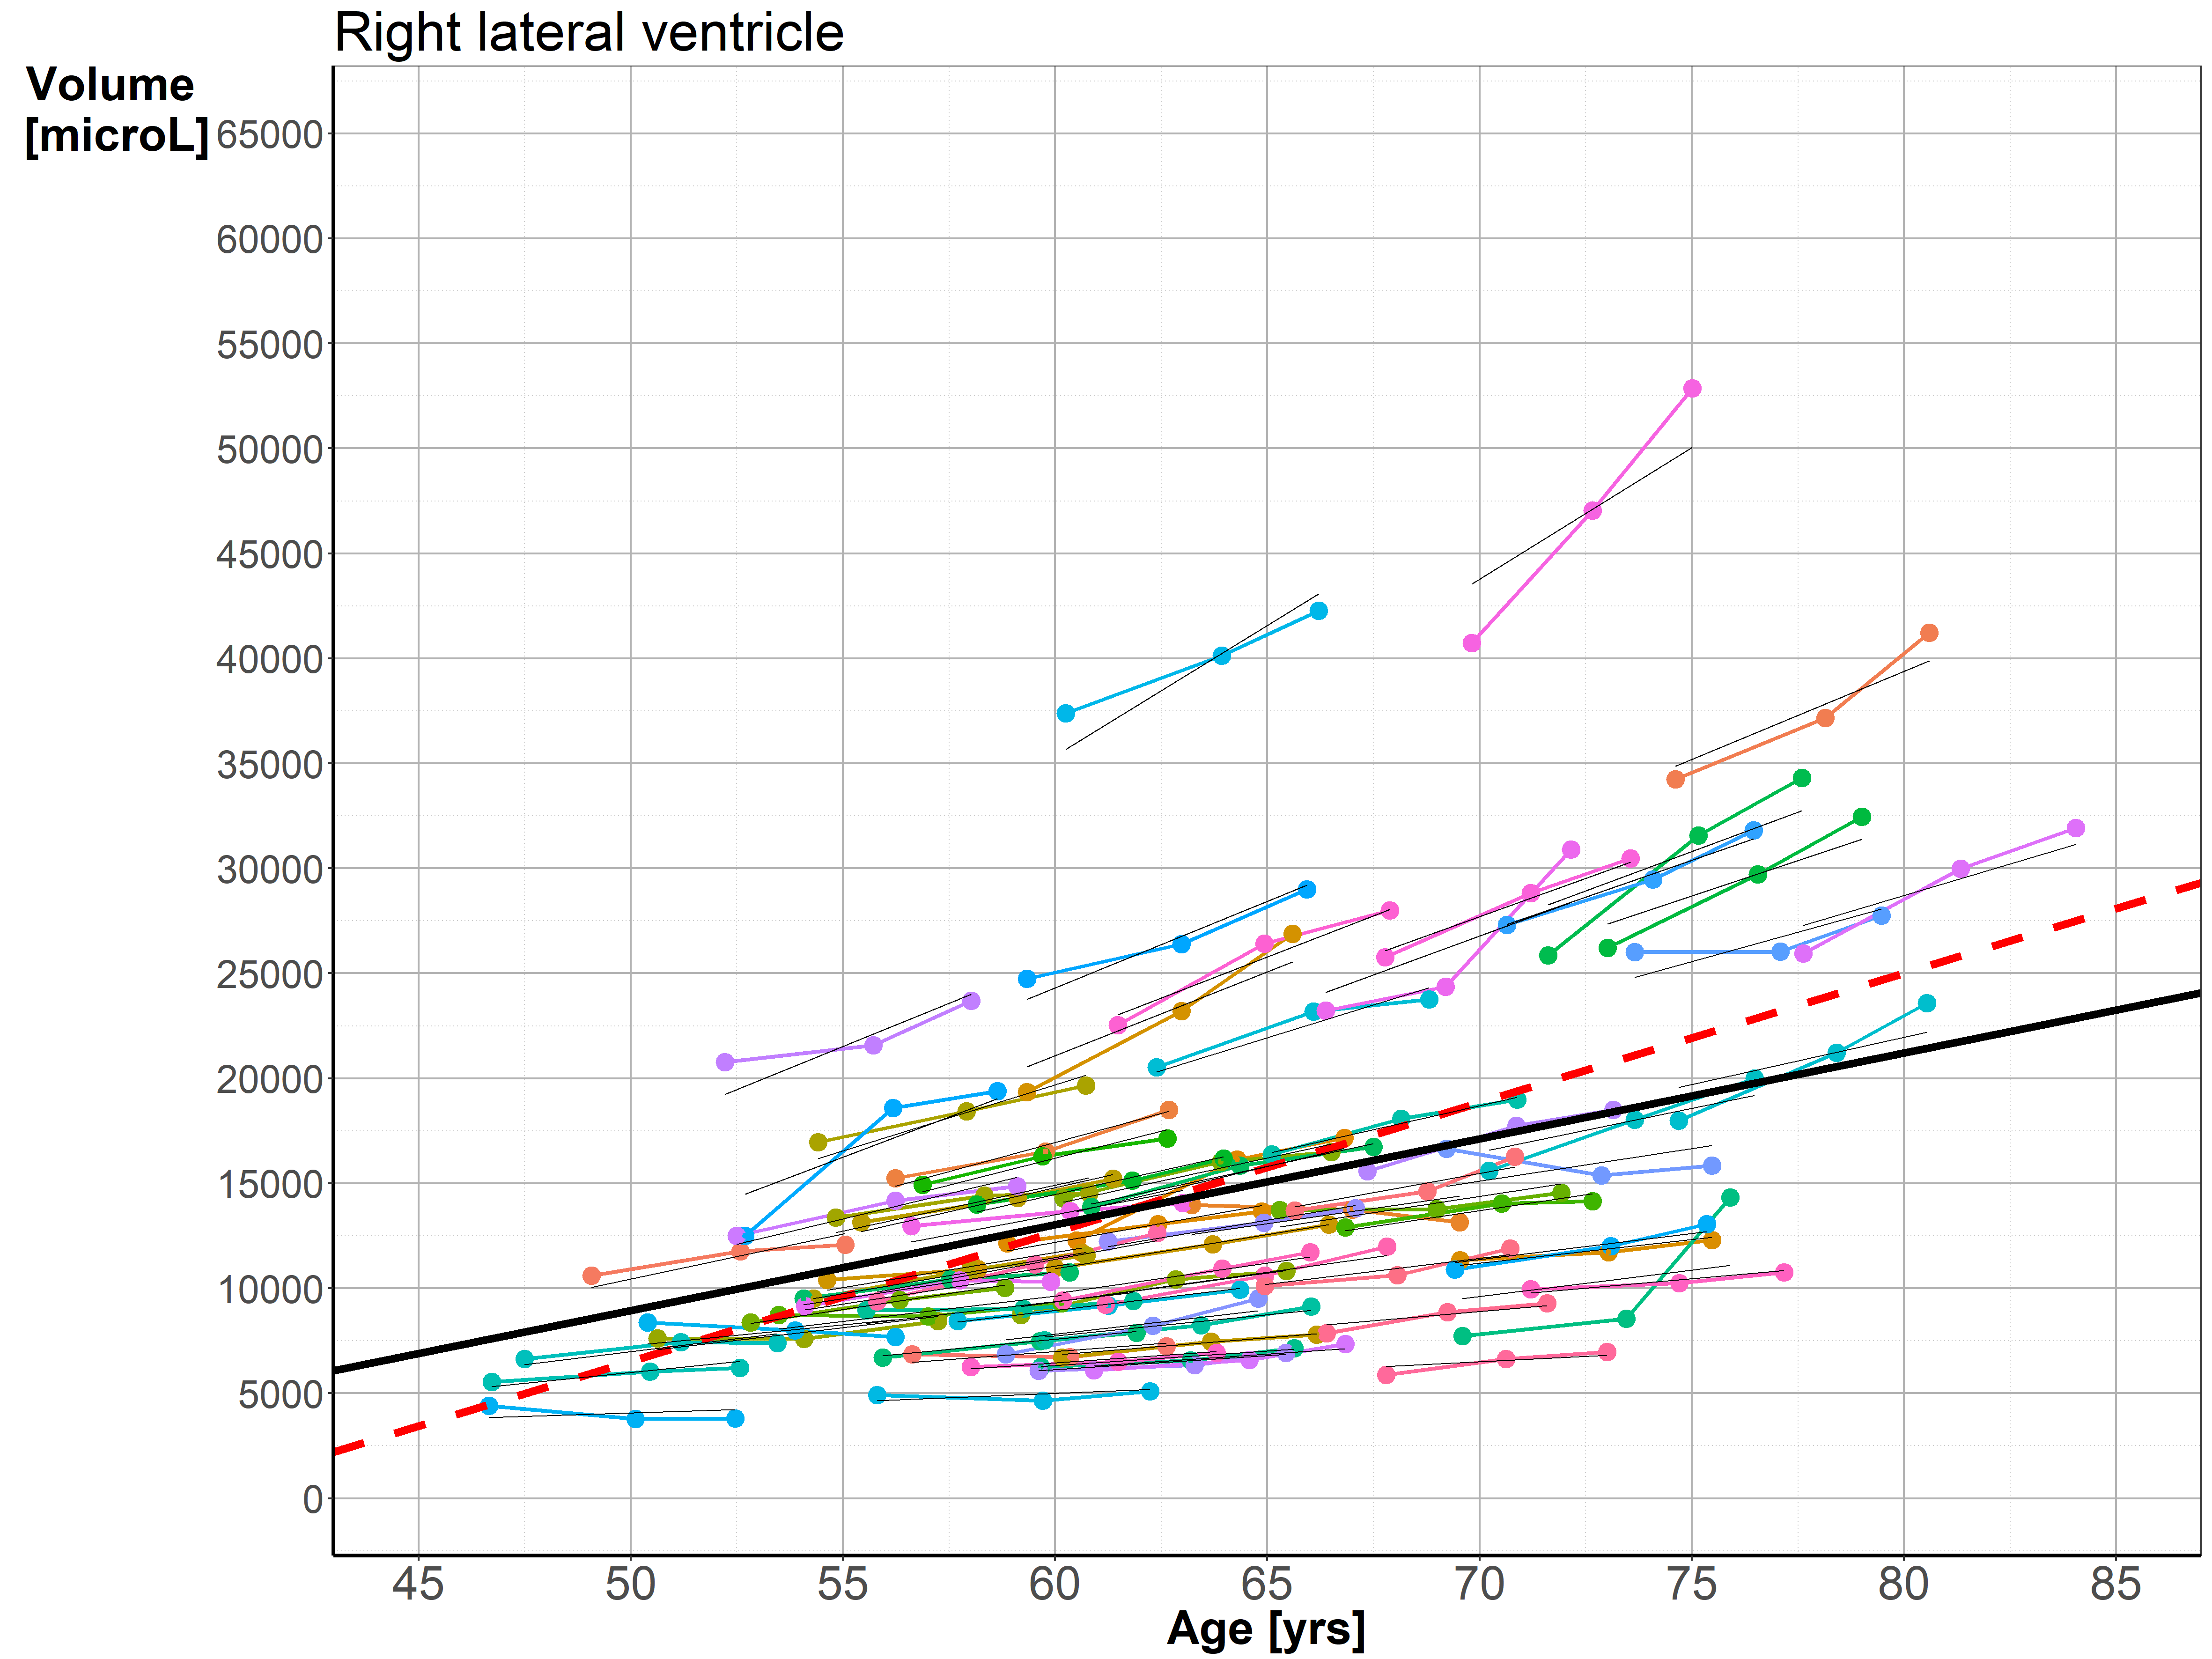

In [40]:
# %R print(g21)
Image(filename='../figures/02_lvv_ri_rpy2_lmer_right_ventricle.png', width=900)

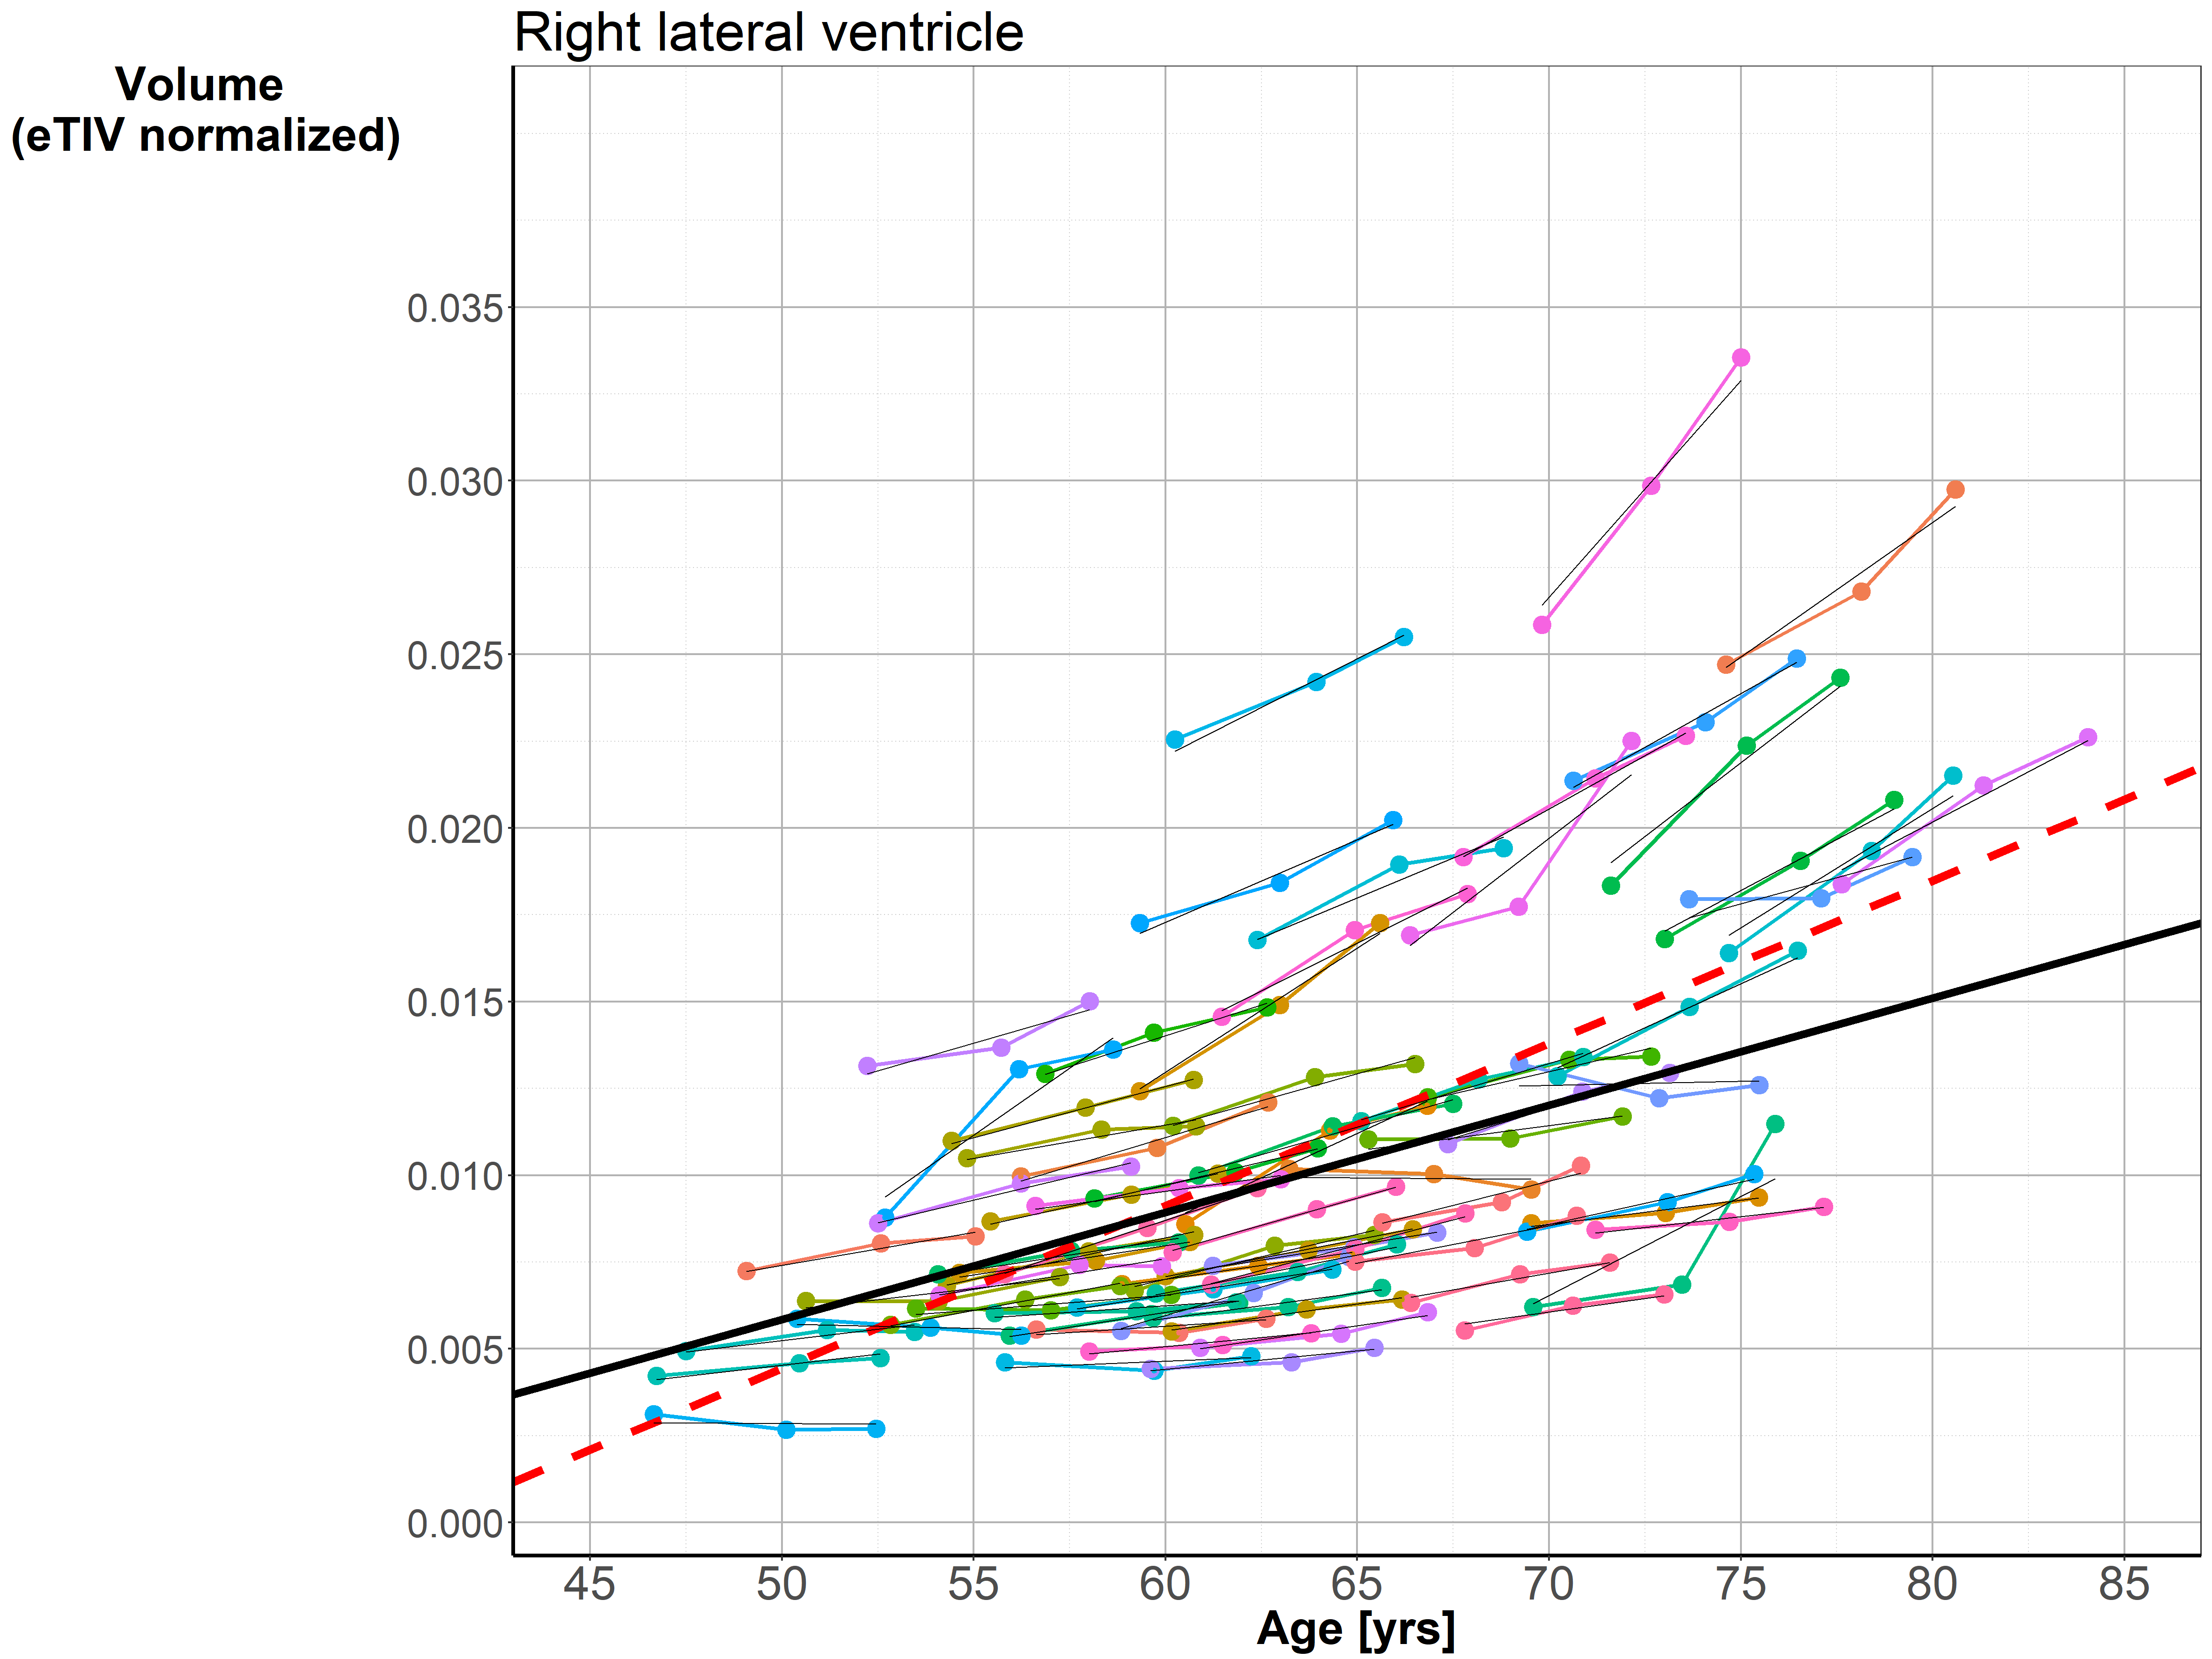

In [41]:
# Needs a run initialized with
# eTIV_NORMALIZED = True

Image(filename='../figures/02_lvv_ri_rpy2_lmer_right_ventricle_eTIV_norm.png', width=900)

In [42]:
%R names(df.lmer.L)

array(['subj', 'yrW1', 'yrW2', 'yrW3', 'left_lvvW1', 'left_lvvW2',
       'left_lvvW3', 'b0i', 'b1i', 'beta0plusb0i', 'beta1plusb1i',
       'gender', 'RI'], dtype='<U12')

In [43]:
%%R 
x <- as.integer(substring(df.lmer.L$subj,6, 7))
y <- df.lmer.L$gender
df.lmer <- data.frame(x,y)
x_name <- "id"
y_name <- "Gender"
names(df.lmer) <- c(x_name,y_name)

df.lmer$Age1 = df.lmer.L$yrW1
df.lmer$Age2 = df.lmer.L$yrW2
df.lmer$Age3 = df.lmer.L$yrW3

df.lmer$b0iL = df.lmer.L$b0i
df.lmer$b1iL = df.lmer.L$b1i
df.lmer$beta0plusb0iL = df.lmer.L$beta0plusb0i
df.lmer$beta1plusb1iL = df.lmer.L$beta1plusb1i

df.lmer$b0iR = df.lmer.R$b0i
df.lmer$b1iR = df.lmer.R$b1i
df.lmer$beta0plusb0iR = df.lmer.R$beta0plusb0i
df.lmer$beta1plusb1iR = df.lmer.R$beta1plusb1i

df.lmer$LatVentL1 = df.lmer.L$left_lvvW1
df.lmer$LatVentL2 = df.lmer.L$left_lvvW2
df.lmer$LatVentL3 = df.lmer.L$left_lvvW3

df.lmer$LatVentR1 = df.lmer.R$right_lvvW1
df.lmer$LatVentR2 = df.lmer.R$right_lvvW2
df.lmer$LatVentR3 = df.lmer.R$right_lvvW3

df.lmer$RI3 = df.lmer.L$RI   # Response Inhibition, wave 3
df.lmer$RI3resid = df.lmer.L$RIresid   # Response Inhibition residuals (full model12 from 01_)

In [44]:
%R print(colnames(df.lmer))

array(['id', 'Gender', 'Age1', 'Age2', 'Age3', 'b0iL', 'b1iL',
       'beta0plusb0iL', 'beta1plusb1iL', 'b0iR', 'b1iR', 'beta0plusb0iR',
       'beta1plusb1iR', 'LatVentL1', 'LatVentL2', 'LatVentL3',
       'LatVentR1', 'LatVentR2', 'LatVentR3', 'RI3'], dtype='<U13')

In [45]:
# Converting the R dataframes to Pandas DataFrames using Rpy2
# https://pandas.pydata.org/pandas-docs/stable/r_interface.html
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

#pd_df_lmer = r['df.lmer']
#pd_df_lmer.head().T.round(2)

In [46]:
#pd_df_lmer.describe().T.round(4)

In [47]:
#dff = pd_df_lmer.copy()
# pd.DataFrame(dff.count())
#dff.info()

## Model-based (lmer) feature design

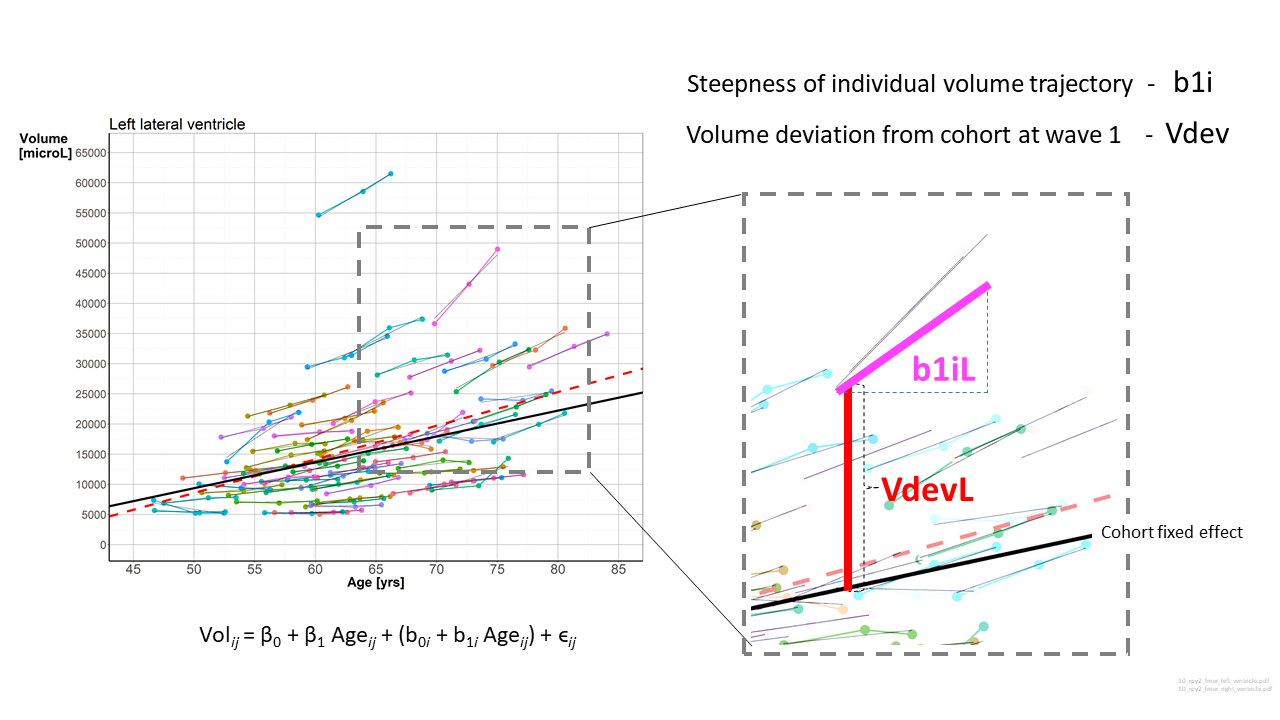

In [48]:
Image('../assets/Fig_2_LME_derived_features.png', width=900)

In [49]:
# Derive new feature, related to wave1

def volFixed(x, a_f, b_f):
    '''
    Age at wave 1: x = dff.Age1
      a_f = dff.beta1L = dff.beta1plusb1iL - dff.b1iL
      b_f = dff.beta0plusb0iL - dff.b0iL
    Fixed effects: y_f = a_f x + b_f
    '''
    return a_f*x + b_f

    
def volDeviation(x, a_f, b_f, a_r, b_r):
    '''
    Age at wave 1: x = dff.Age1
    Fixed effects: y_f = a_f x + b_f
      a_f = dff.beta1L = dff.beta1plusb1iL - dff.b1iL
      b_f = dff.beta0plusb0iL - dff.b0iL
    Random effects: y_r = a_r x + b_r
      a_r = dff.beta1plusb1iL
      b_r = dff.beta0plusb0iL
    Vol_deviation = y_r - y_f
    '''

    y_f = a_f*x + b_f
    y_r = a_r*x + b_r
    return y_r - y_f

In [50]:
x = dff.Age1

# Left

a_f = dff['beta1plusb1iL'].values - dff['b1iL'].values
b_f = dff['beta0plusb0iL'].values - dff['b0iL'].values
a_r = dff['beta1plusb1iL'].values
b_r = dff['beta0plusb0iL'].values

print('LH fixed effects: (a_f, b_f) = (beta1L, beta0L) = (%.4f, %.4f)' % (a_f[0], b_f[0]))
dff['VdevL'] = volDeviation(x, a_f, b_f, a_r, b_r)
dff['Vfixed1L'] = volFixed(x, a_f, b_f)
dff['Vfixed1diffL'] = dff['LatVentL1'] - dff['Vfixed1L']

NameError: name 'dff' is not defined

In [72]:
# Right

a_f = dff['beta1plusb1iR'].values - dff['b1iR'].values
b_f = dff['beta0plusb0iR'].values - dff['b0iR'].values
a_r = dff['beta1plusb1iR'].values
b_r = dff['beta0plusb0iR'].values

print('RH fixed effects: (a_f, b_f) = (beta1R, beta0R) = (%.4f, %.4f)' % (a_f[0], b_f[0]))
dff['VdevR'] = volDeviation(x, a_f, b_f, a_r, b_r)
dff['Vfixed1R'] = volFixed(x, a_f, b_f)
dff['Vfixed1diffR'] = dff['LatVentR1'] - dff['Vfixed1R']

RH fixed effects: (a_f, b_f) = (beta1R, beta0R) = (408.6075, -11482.2242)


In [73]:
pd.DataFrame(dff[['id', 'Age1', 'b0iL', 'b1iL', 'LatVentL1', 'Vfixed1L', 'Vfixed1diffL', 'VdevL']].round(4)).head()

,id,Age1,b0iL,b1iL,LatVentL1,Vfixed1L,Vfixed1diffL,VdevL
0,1,56.63,15699.1506,-401.8109,5321.4,12229.1760,-6907.7760,-7055.4005
1,2,49.07,11389.8550,-191.1450,11038.6,8989.2374,2049.3626,2010.3692
2,3,74.61,-27639.5084,501.1001,29718.4,19934.7444,9783.6556,9747.5737
3,4,56.23,-3996.4079,242.9115,21830.1,12057.7507,9772.3493,9662.5032
4,5,63.22,35508.9522,-530.8482,17205.1,15053.4082,2151.6918,1948.7297


In [74]:
dff['errorL'] = dff['Vfixed1diffL'] - dff['VdevL']

In [75]:
pd.DataFrame(dff[['id', 'Age1', 'b0iR', 'b1iR', 'LatVentR1', 'Vfixed1R', 'Vfixed1diffR', 'VdevR']].round(4)).head()

,id,Age1,b0iR,b1iR,LatVentR1,Vfixed1R,Vfixed1diffR,VdevR
0,1,56.63,9303.7517,-255.8375,6855.2,11657.2207,-4802.0207,-5184.3248
1,2,49.07,579.8084,18.4452,10611.6,8568.1477,2043.4523,1484.9150
2,3,74.61,-16362.8828,431.9485,34241.0,19003.9843,15237.0157,15864.7936
3,4,56.23,-4710.9595,143.7001,15243.9,11493.7777,3750.1223,3369.2981
4,5,63.22,5763.1296,-119.3152,13962.1,14349.9444,-387.8444,-1779.9775


In [124]:
dff['errorR'] = dff['Vfixed1diffR'] - dff['VdevR']

In [125]:
pd.DataFrame(dff[['Age1', 'b0iL', 'b1iL', 'LatVentL1', 'Vfixed1L', 'Vfixed1diffL', 'VdevL', 'errorL']].mean().round(5))

,0
Age1,60.74824
b0iL,0.00000
b1iL,-0.00000
LatVentL1,14994.09730
Vfixed1L,13986.60607
Vfixed1diffL,1007.49123
VdevL,1002.89675
errorL,4.59448


In [126]:
pd.DataFrame(dff[['Age1', 'b0iR', 'b1iR', 'LatVentR1', 'Vfixed1R', 'Vfixed1diffR', 'VdevR', 'errorR']].mean().round(5))

,0
Age1,60.74824
b0iR,0.00000
b1iR,-0.00000
LatVentR1,13777.27703
Vfixed1R,12638.30312
Vfixed1diffR,1138.97390
VdevR,1126.01429
errorR,12.95961


### Check summary statistics

In [127]:
pd_df = dff.copy()
pd_df.describe(include=[np.number]).round(4).T

,count,mean,std,min,25%,50%,75%,max
id,74.0,37.5000,21.5058,1.0000,19.2500,37.5000,55.7500,74.0000
Age1,74.0,60.7482,7.2548,46.6600,55.6125,59.8750,66.3925,77.6300
Age2,74.0,64.2839,7.2110,50.1100,59.3175,63.5550,69.2300,81.3300
Age3,74.0,66.8126,7.1855,52.4600,61.8600,66.0200,72.0925,84.0500
b0iL,74.0,0.0000,19108.3773,-92465.1429,-6894.0484,3257.8695,10098.4284,35804.7260
b1iL,74.0,-0.0000,370.1075,-736.3824,-219.9399,-84.9639,213.9882,1605.7329
beta0plusb0iL,74.0,-12058.0825,19108.3773,-104523.2254,-18952.1309,-8800.2131,-1959.6541,23746.6435
beta1plusb1iL,74.0,428.7316,370.1075,-307.6508,208.7917,343.7676,642.7198,2034.4645
b0iR,74.0,0.0000,18775.3259,-84955.1330,-3666.5688,5729.1556,10642.1254,28892.1231
b1iR,74.0,-0.0000,357.1553,-478.8060,-236.8602,-96.8572,81.3248,1575.2134


In [128]:
pd.DataFrame([pd_df['id'], pd_df['Age3'], pd_df['VdevL'], pd_df['VdevR']]).round(4)

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
id,1.0000,2.0000,3.0000,4.0000,5.0000,6.0000,7.0000,8.0000,9.0000,10.0000,...,65.0000,66.0000,67.0000,68.0000,69.0000,70.0000,71.0000,72.0000,73.0000,74.0000
Age3,62.6200,55.0500,80.5900,62.6800,69.5300,66.8200,64.8700,75.4700,65.5900,60.6300,...,67.8800,63.8000,77.1700,66.0100,67.8200,62.4000,73.0000,71.5900,70.7200,70.8300
VdevL,-7043.6020,2023.1748,9741.9981,9671.4956,1970.5095,1359.3528,6505.4006,-5823.1996,4081.0624,928.3855,...,6117.4765,-7586.3877,-8080.7367,-2518.1817,300.3477,-1752.9692,-8166.9608,-7840.0093,-2119.8942,-207.1494
VdevR,-4203.2924,2955.5262,15582.0242,4323.0331,-11.1935,185.8433,209.4370,-5154.3140,7376.2625,214.1908,...,9862.4839,-5289.6997,-7203.0938,-2904.3142,-3567.0198,-1130.4225,-9560.7572,-6996.2345,-4400.1692,-1105.3974


### Select variables for analysis

In [129]:
pd_df.columns

Index(['id', 'Gender', 'Age1', 'Age2', 'Age3', 'b0iL', 'b1iL', 'beta0plusb0iL',
       'beta1plusb1iL', 'b0iR', 'b1iR', 'beta0plusb0iR', 'beta1plusb1iR',
       'LatVentL1', 'LatVentL2', 'LatVentL3', 'LatVentR1', 'LatVentR2',
       'LatVentR3', 'RI3', 'RI3resid', 'VdevL', 'Vfixed1L', 'Vfixed1diffL',
       'VdevR', 'Vfixed1R', 'Vfixed1diffR', 'errorL', 'errorR'],
      dtype='object')

In [130]:
myvars = [
    'id',
    'Gender',
    'Age3',
    'b1iL',
    'b1iR',
    'VdevL',
    'VdevR',
    'RI3',
    'RI3resid'
]

In [131]:
pd_df.groupby("Gender")[myvars].describe(include="all", percentiles = [0.5]).round(4).T

Gender                 F        M
id       count        48       26
         unique      NaN      NaN
         top         NaN      NaN
         freq        NaN      NaN
         mean    39.8125  33.2308
         std     20.0676  23.7526
         min           1        2
         50%        37.5       34
         max          72       74
Gender   count        48       26
         unique        1        1
         top           F        M
         freq         48       26
         mean        NaN      NaN
         std         NaN      NaN
         min         NaN      NaN
         50%         NaN      NaN
         max         NaN      NaN
Age3     count        48       26
         unique      NaN      NaN
         top         NaN      NaN
         freq        NaN      NaN
         mean    66.4183  67.5404
         std       6.872   7.8186
         min       52.57    52.46
         50%      65.545   66.765
         max       80.54    84.05
b1iL     count        48       26
         unique      NaN      NaN
         top         NaN      NaN
...                  ...      ...
VdevL    min    -8928.98  -5823.2
         50%    -1888.48  2994.11
         max     19647.1  40492.3
VdevR    count        48       26
         unique      NaN      NaN
         top         NaN      NaN
         freq        NaN      NaN
         mean   -774.732  4635.08
         std     5918.29  6637.85
         min    -9560.76 -5154.31
         50%    -1079.06  3527.05
         max     25026.3  24467.4
RI3      count        48       26
         unique      NaN      NaN
         top         NaN      NaN
         freq        NaN      NaN
         mean    56.0208  58.7692
         std     14.9503  13.6185
         min          35       40
         50%        52.5       57
         max         102       94
RI3resid count        48       26
         unique      NaN      NaN
         top         NaN      NaN
         freq        NaN      NaN
         mean     0.4086  -0.7543
         std     12.6842   9.6744
         min    -18.7856 -17.7114
         50%     -2.3557   -2.032
         max     29.8743  22.6642

[81 rows x 2 columns]

### $\LaTeX$ related

In [132]:
# print(pd_df.groupby("Sex")[myvars].describe(include="all", percentiles = [0.5]).round(2).T.to_latex())

#### Cut and paste LaTeX code to new cell
%%latex  cell

substitute tabular with array as "MathJax doesn't implement tabular", and toprule, midrule with hline <br>
https://github.com/mathjax/mathjax-docs/wiki/LaTeX-Tabular-environment


### Save lmer features

In [133]:
dfmri = pd_df.copy()
dfmri = dfmri[myvars].drop('id', axis=1)
dfmri.head().round(4)

,Gender,Age3,b1iL,b1iR,VdevL,VdevR,RI3,RI3resid
0,F,62.62,-403.1430,-342.5620,-7043.6020,-4203.2924,66.0,7.0764
1,M,55.05,-192.3108,-155.4509,2023.1748,2955.5262,85.0,10.0160
2,M,80.59,504.2477,649.6584,9741.9981,15582.0242,71.0,10.9713
3,M,62.68,242.6496,83.6578,9671.4956,4323.0331,41.0,-4.3902
4,M,69.53,-535.1822,-450.1273,1970.5095,-11.1935,62.0,-3.0089


In [134]:
# Save the lmer feature data to the present repository as .csv
if eTIV_NORMALIZED:
    dfmri.to_csv('../results/02_lvv_ri_lmer_feature_data_eTIV_norm.csv', header=True, index=False)
else:
    dfmri.to_csv('../results/02_lvv_ri_lmer_feature_data.csv', header=True, index=False)    